# Multiscale Solar Water Heating System Simulation Tool 

## Contents


* **Project input**: minimum user requirement
* **Weather**: California (CA) climate zones available in the database 
* **Loads**: example CA hourly loads available in the database
* **Performance parameters**: defaults provided, user edits optional, such as providing insulation thickness for tanks
* **Component sizing**: sizing rules provided, user edits optional, such as providing the actual length of the piping
* **System simulation examples** with plots and summaries for all system configurations

### System configurations
* Basecase gas tank water heater (WH)
* Active solar thermal system with a new tankless gas WH backup
* Active solar thermal system with a retrofit tankless gas WH backup


# Setup 
## Import modules 

In [1]:
import unittest
import os

# please restart the kernel if rerunning this for the paths to align
os.chdir('../')

import numpy as np
import pandas as pd

from mswh.comm.label_map import SwhLabels
from mswh.system.components import Converter, Storage
from mswh.system.source_and_sink import SourceAndSink
from mswh.system.models import System
from mswh.system.source_and_sink import SourceAndSink

from mswh.tools.unit_converters import UnitConv, Utility
from mswh.comm.sql import Sql

from mswh.tools.plots import Plot

import datetime

import logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

# label maps
c = SwhLabels().set_hous_labels()
s = SwhLabels().set_prod_labels()
r = SwhLabels().set_res_labels()

# pd.options.display.float_format = '{:,.3f}'.format

## Project inputs
* The user in the default case only needs to specify household occupancy and a climate in CA

In [2]:
# Add a value to the list for each additional household in a community scale project

# Community scale household occupancies for 4 households
occ_com = [3, 3, 3, 3]

# Individual scale household occupancy
occ_ind = [3]

# indicate whether any occupants are at home during the day
at_home_com = ['n', 'n', 'n', 'n']
at_home_ind = ['n']

# Example climate zones in CA
cold_cz = '01'
hot_cz = '15'
val_cz = '03'

## Load in input database (DB)

In [3]:
weather_db_path = os.path.join(os.getcwd(), 'mswh/comm/mswh_system_input.db')

db = Sql(weather_db_path)

try:
    # read table names for all tables in a
    # {table name : sheet name} form
    inputs = db.tables2dict(close = True)
except:
    msg = 'Failed to read input tables from {}.'
    log.error(msg.format(inpath))

## Generate weather data
* Includes calculation of the incident irradiation with the default tilt and azimuth

In [4]:
source_and_sink = SourceAndSink(\
    input_dfs = inputs)

weather_cold = source_and_sink.irradiation_and_water_main(
    cold_cz, method='isotropic diffuse')

weather_hot = source_and_sink.irradiation_and_water_main(
    hot_cz, method='isotropic diffuse')

weather_val = source_and_sink.irradiation_and_water_main(
    val_cz, method='isotropic diffuse')

INFO:mswh.system.source_and_sink:The user did not provide a numpy random state object. Initiating one with a provided or default seed value = 123.


## Select hourly hot water draw profiles from DB

In [5]:
# Returns hourly load profiles in m3/h and the peak load in gal/h for each household in the project

rs = np.random.RandomState(123)

# peakload_com output shows the consumer ID, load ID and the peak hourly end-use load
# loads_com holds the loads itself, with the associated consumer ID and occupancy

loads_com, peakload_com = \
    SourceAndSink._make_example_loading_inputs(
    inputs, c, rs,
    occupancy = occ_com, at_home = at_home_com)

loads_indiv, peakload_indiv = \
    SourceAndSink._make_example_loading_inputs(
    inputs, c, rs,
    occupancy = occ_ind, at_home = at_home_ind)

peakload_com

Consumer ID Load ID  Peak End-Use Load [gal]
0            1     109                    40.00
1            2      88                    42.00
2            3      46                    42.00
3            4      73                    44.75

In [6]:
peakload_indiv

Consumer ID Load ID  Peak End-Use Load [gal]
0            1      46                     42.0

## Set performance parameters

* Active solar thermal system

In [7]:
# Community scale system (includes distribution pump parameters)

sol_the_sys_params_com = pd.DataFrame(data = \
            [[s['the_sto'], s['f_upper_vol'], .5], \
             [s['the_sto'], s['ins_thi'], .085], \
             [s['the_sto'], s['spec_hea_con'], .04], \
             [s['the_sto'], s['t_tap_set'], 322.04], \
             [s['the_sto'], s['h_vs_r'], 6.], \
             [s['the_sto'], s['dt_appr'], 2.], \
             [s['the_sto'], s['t_max_tank'], 344.15], \
             [s['the_sto'], s['eta_coil'], .84], \
             [s['the_sto'], s['circ'], 0.], \
             [s['sol_col'], s['interc_hwb'], .753], \
             [s['sol_col'], s['slope_hwb'], -4.025],\
             [s['sol_pump'], s['eta_sol_pump'], .85], \
             [s['piping'], s['pipe_spec_hea_con'], .0175], \
             [s['piping'], s['pipe_ins_thick'], .008], \
             [s['piping'], s['flow_factor'], .8], \
             [s['piping'], s['dia_len_exp'], 0.43082708345352605], \
             [s['piping'], s['dia_len_sca'], 0.007911283766743384],\
             [s['piping'], s['discr_diam_m'], \
               '[0.0127, 0.01905, 0.0254, '\
               '0.03175, 0.0381, 0.0508, 0.0635, 0.0762, 0.1016]'],\
             [s['piping'], s['circ'], False], \
             [s['piping'], s['long_br_len_fr'], 1.], \
             [s['dist_pump'], s['eta_dist_pump'], .85]], \
            columns = \
             [s['comp'], s['param'], s['param_value']])

sol_the_sys_params_com

Component                         Performance Parameter  \
0   thermal storage tank                         upper volume fraction   
1   thermal storage tank                          insulation thickness   
2   thermal storage tank                    specific heat conductivity   
3   thermal storage tank                      tap temperature setpoint   
4   thermal storage tank                             height vs. radius   
5   thermal storage tank             temperature difference (approach)   
6   thermal storage tank                           maximum temperature   
7   thermal storage tank                               coil efficiency   
8   thermal storage tank                                   circulation   
9        solar collector                                    interc hwb   
10       solar collector                                     slope hwb   
11            solar pump          nominal distribution pump efficiency   
12                piping  piping insulation specific heat conductivity   
13                piping                   piping insulation thickness   
14                piping                                   flow factor   
15                piping                  diameter vs. length exponent   
16                piping                    diameter vs. length scaler   
17                piping                            discrete diameters   
18                piping                                   circulation   
19                piping                longest branch length fraction   
20     distribution pump                 nominal solar pump efficiency   

                          Performance Parameter Value  
0                                                 0.5  
1                                               0.085  
2                                                0.04  
3                                              322.04  
4                                                 6.0  
5                                                 2.0  
6                                              344.15  
7                                                0.84  
8                                                 0.0  
9                                               0.753  
10                                             -4.025  
11                                               0.85  
12                                             0.0175  
13                                              0.008  
14                                                0.8  
15                                           0.430827  
16                                           0.007911  
17  [0.0127, 0.01905, 0.0254, 0.03175, 0.0381, 0.0...  
18                                              False  
19                                                1.0  
20                                               0.85

In [8]:
# Individual scale system, assuming a distribution pump is not needed similarly to a basecase gas tank WH

last_row_for_indiv = sol_the_sys_params_com.shape[0] - 1 - \
    sol_the_sys_params_com.loc[\
    sol_the_sys_params_com[s['comp']] == s['dist_pump'], :].\
    shape[0]

sol_the_sys_params_indiv = sol_the_sys_params_com.loc[:last_row_for_indiv,:]
sol_the_sys_params_indiv

sol_the_sys_params_indiv

Component                         Performance Parameter  \
0   thermal storage tank                         upper volume fraction   
1   thermal storage tank                          insulation thickness   
2   thermal storage tank                    specific heat conductivity   
3   thermal storage tank                      tap temperature setpoint   
4   thermal storage tank                             height vs. radius   
5   thermal storage tank             temperature difference (approach)   
6   thermal storage tank                           maximum temperature   
7   thermal storage tank                               coil efficiency   
8   thermal storage tank                                   circulation   
9        solar collector                                    interc hwb   
10       solar collector                                     slope hwb   
11            solar pump          nominal distribution pump efficiency   
12                piping  piping insulation specific heat conductivity   
13                piping                   piping insulation thickness   
14                piping                                   flow factor   
15                piping                  diameter vs. length exponent   
16                piping                    diameter vs. length scaler   
17                piping                            discrete diameters   
18                piping                                   circulation   
19                piping                longest branch length fraction   

                          Performance Parameter Value  
0                                                 0.5  
1                                               0.085  
2                                                0.04  
3                                              322.04  
4                                                 6.0  
5                                                 2.0  
6                                              344.15  
7                                                0.84  
8                                                 0.0  
9                                               0.753  
10                                             -4.025  
11                                               0.85  
12                                             0.0175  
13                                              0.008  
14                                                0.8  
15                                           0.430827  
16                                           0.007911  
17  [0.0127, 0.01905, 0.0254, 0.03175, 0.0381, 0.0...  
18                                              False  
19                                                1.0

* Basecase and backup gas tank water heater (WH)

In [9]:
gas_tank_wh_params = pd.DataFrame(data = \
    [[s['gas_tank'], s['tank_re'], .78, '-'], \
     [s['gas_tank'], s['ins_thi'], .03, 'm'], \
     [s['gas_tank'], s['spec_hea_con'], .081, 'W/mK'], \
     [s['gas_tank'], s['t_tap_set'], 322.04, 'K']], \
    columns = \
     [s['comp'], s['param'], s['param_value'], s['param_unit']])

gas_tank_wh_params

Component       Performance Parameter  Performance Parameter Value  \
0  gas tank WH    tank recovery efficiency                        0.780   
1  gas tank WH        insulation thickness                        0.030   
2  gas tank WH  specific heat conductivity                        0.081   
3  gas tank WH    tap temperature setpoint                      322.040   

  Performance Parameter Unit  
0                          -  
1                          m  
2                       W/mK  
3                          K

* Gas tankless WH

In [10]:
gas_tankless_wh_params = pd.DataFrame(data = [[s['gas_burn'], s['comb_eff'], .85, '-']], \
    columns = [s['comp'], s['param'], s['param_value'], s['param_unit']])
gas_tankless_wh_params

Component  Performance Parameter  Performance Parameter Value  \
0  gas burner  combustion efficiency                         0.85   

  Performance Parameter Unit  
0                          -

* All performance parameters

In [11]:
# this input table provides all available component performance parameters
inputs['component_performance']

Component ID                         Performance Parameter  \
0              1                                    interc hwb   
1              1                                     slope hwb   
2              1                                     interc cd   
3              1                                         a1 cd   
4              1                                         a2 cd   
5              4                                 PV efficiency   
6              4                    fraction of active PV area   
7              4                         reference irradiation   
8              5                      tank recovery efficiency   
9              5                      tap temperature setpoint   
10             5                          insulation thickness   
11             5                    specific heat conductivity   
12             7                          insulation thickness   
13             7                    specific heat conductivity   
14             7                         upper volume fraction   
15             7                             height vs. radius   
16             7             temperature difference (approach)   
17             7                           maximum temperature   
18             7                      tap temperature setpoint   
19             7                               coil efficiency   
20             8                         combustion efficiency   
21             9                                    efficiency   
22            10                        rated heating capacity   
23            10                                     rated COP   
24            10                                        c1_cop   
25            10                                        c2_cop   
26            10                                        c3_cop   
27            10                                        c4_cop   
28            10                                        c5_cop   
29            10                                        c6_cop   
30            10                                   c1_heat_cap   
31            10                                   c2_heat_cap   
32            10                                   c3_heat_cap   
33            10                                   c4_heat_cap   
34            10                                   c5_heat_cap   
35            10                                   c6_heat_cap   
36            12          nominal distribution pump efficiency   
37            13                 nominal solar pump efficiency   
38            14  piping insulation specific heat conductivity   
39            14                   piping insulation thickness   
40            14                    diameter vs. length scaler   
41            14                  diameter vs. length exponent   
42            14                 single-family attached scaler   
43            14                 single-family detached scaler   
44            14                            discrete diameters   
45            14                                   flow factor   
46            14                                   circulation   
47            14                longest branch length fraction   
48            15                           DC to AC efficiency   

                          Performance Parameter Value  \
0                                               0.753   
1                                              -4.025   
2                                                0.75   
3                                              -3.688   
4                                             -0.0055   
5                                                0.16   
6                                                 1.0   
7                                              1000.0   
8                                                0.78   
9                                              322.04   
10                                               0.03   
11                 

In [12]:
inputs['sys_3_components']

Component ID                    Component  \
0              1              solar collector   
1              2              solar collector   
2              3                           pv   
3              4                           pv   
4              5                  gas tank WH   
5              6  electric resistance tank WH   
6              7         thermal storage tank   
7              8                   gas burner   
8              9   electric resistance heater   
9             10                    heat pump   
10            11              battery storage   
11            12            distribution pump   
12            13                   solar pump   
13            14                       piping   
14            15                     inverter   

                                 Component Technology Component Size Unit  
0                                          flat plate                  m2  
1                                             tubular                  m2  
2                                    monochrystalline                   W  
3                                    polychrystalline                   W  
4                  conventional gas tank water heater                  m3  
5   conventional electric resistance tank water he...                  m3  
6           thermal storage tank with an in-tank coil                  m3  
7                                          gas burner                   W  
8                            in-tank or instantaneous                   W  
9                                             in-tank                   W  
10                          stores PV generated power                 kWh  
11                        fixed-speed circulator pump                   W  
12                        fixed-speed circulator pump                   W  
13                                          dhw pipes                   m  
14                                              dc-ac                   W

In [13]:
to_doc = inputs['component_performance'].merge(inputs['sys_3_components'], on = "Component ID", how = "left")

## Component sizing

Note that backup is sized to full load.

* Gas tank WH: DOE sizing rule based on peak hourly demand +-2 gal

In [14]:
# Basecase gas tank WH

# in m3
gas_tank_size_indiv = UnitConv(peakload_indiv.loc[0, c['max_load']]).m3_gal(unit_in = 'gal')
gas_tank_size_indiv

# Individual household, backup
# same as the basecase sizing

0.158987304

In [15]:
# Community scale, backup

# get peak loads for each household
peakload_com['gas_tank_size_com'] = peakload_com[\
    c['max_load']].apply(lambda x: UnitConv(x).m3_gal(unit_in = 'gal'))
peakload_com.index = peakload_com[c['id']]

peakload_com

Consumer ID Load ID  Peak End-Use Load [gal]  gas_tank_size_com
Consumer ID                                                                 
1                      1     109                    40.00           0.151416
2                      2      88                    42.00           0.158987
3                      3      46                    42.00           0.158987
4                      4      73                    44.75           0.169397

* Active solar thermal system: CSI Handbook sizing rules

In [16]:
# CSI demand estimate
def demand_estimate(occ):
    if occ == 1:
        return 20.
    if occ == 2:
        return 35.
    else:
        return 35.+10.*(occ-2.)
    
col_area_scaler = 1.2 #(CSI sizing rule: upper limit 1.25)
tank_vol_scaler = 1.3 #(CSI sizing rule: lower limit 1.25)

# Individual household (without a distribution pump)

# get demand estimate
demand_estimate_ind = demand_estimate(occ_ind[0])

# CSI sizing rules
col_area_ind_sqft = demand_estimate_ind * col_area_scaler
tank_vol_ind_gal = col_area_ind_sqft * tank_vol_scaler

col_area_ind = UnitConv(col_area_ind_sqft).sqft_m2()
tank_vol_ind = UnitConv(tank_vol_ind_gal).m3_gal(unit_in = 'gal')

# Community scale (with a distribution pump)

# get demand estimate
demand_estimate_com = 0.
for inx, row in loads_com.iterrows():
    demand_estimate_com += demand_estimate(row[c['occ']])

col_area_com_sqft = demand_estimate_com * col_area_scaler
tank_vol_com_gal = col_area_com_sqft * tank_vol_scaler

col_area_com = UnitConv(col_area_com_sqft).sqft_m2()
tank_vol_com = UnitConv(tank_vol_com_gal).m3_gal(unit_in = 'gal')

* Gas tankless WH: Based on the WH efficiency standards analysis and input powers collected online

In [17]:
def gas_tankles_size_W(occupancy):
    size = 24875.*occupancy**0.5175
    return size

* Solar pump

In [18]:
# solar pump
solar_pump_w_indiv = 7.5101 * sum(occ_ind) ** 0.5322
solar_pump_w_com = 7.5101 * sum(occ_com) ** 0.5322

### Distribution system

* Piping

In [19]:
# If the length of community piping installation is unknown, use this estimate

# individual 
pipe_m_indiv = 0 # this can be set to a real value if it is known. It is set to 0 here since the part of piping inside of a 
# household is assumed to have negligible thermal losses

# community scale

pipe_m_per_hhld = 3.048
# household type distribution pipe length scalers for communities with attached and detached single family houses
multifamily = 1.
attached_k = 3.
detached_k = 6.

diameter_scaler=0.00791128
diameter_exponent=0.430827

# The average diameter of the distribution piping is a function of distribution pipe length and it gets autosized 
# within the distribution model, where the first larger value than that theoretically obtained gets selected
# from this list: [0.0127, 0.01905, 0.0254, 0.03175, 0.0381, 0.0508, 0.0635, 0.0762, 0.1016], in m

# The formula is:

# d_m = diameter_scaler * (pipe_m_per_hhld * number_of_households)**diameter_exponent
# To change these parameters, edit values in sol_the_sys_params_{com/indiv} dataframes

d_m = diameter_scaler * (pipe_m_per_hhld * len(occ_com))**diameter_exponent

d_m

0.02323577539362201

* Distribution pump

In [20]:
dist_pump_w = 10.4376 * len(occ_com) ** 0.9277

## Compile component sizes for system simulation

* Basecase gas tank WH

In [21]:
# Individual household

gas_tank_wh_size = pd.DataFrame(
    data = [[s['gas_tank'], gas_tank_size_indiv, 'm3']], columns = [s['comp'], s['cap'], s['cap_unit']])

gas_tank_wh_size

Component  Component Size Component Size Unit
0  gas tank WH        0.158987                  m3

* Solar thermal system, individual household

In [22]:
# Main system

sys_sizes_indiv = pd.DataFrame(data = \
    [[s['sol_col'], col_area_ind, 'm2'], \
     [s['the_sto'], tank_vol_ind, 'm3'], \
     [s['sol_pump'], solar_pump_w_indiv, 'W'], \
     [s['piping'], pipe_m_indiv, 'm']], \
            columns = \
             [s['comp'], s['cap'], s['cap_unit']])

sys_sizes_indiv

Component  Component Size Component Size Unit
0       solar collector        5.016764                  m2
1  thermal storage tank        0.265736                  m3
2            solar pump       13.476268                   W
3                piping        0.000000                   m

In [23]:
# Retrofit: Backup gas tank WH

retrofit_bckp_size_indiv = pd.DataFrame(data = \
            [[1, s['gas_tank'], gas_tank_size_indiv, 'm3']], columns = [c['id'], s['comp'], s['cap'], s['cap_unit']])
demand_estimate_com

180.0

In [24]:
# New: Backup gas tankless WH

new_bckp_size_ind = pd.DataFrame(data = [[1, s['gas_burn'], gas_tankles_size_W(occ_ind[0]), 'W']], \
            columns = [c['id'], s['comp'], s['cap'], s['cap_unit']])

new_bckp_size_ind

Consumer ID   Component  Component Size Component Size Unit
0            1  gas burner    43921.113177                   W

* Solar thermal system, community

In [25]:
# Main system components

sys_sizes_com = pd.DataFrame(data = \
            [[s['sol_col'], col_area_com, 'm2'], \
             [s['the_sto'], tank_vol_com, 'm3'], \
             [s['sol_pump'], solar_pump_w_com, 'W'], \
             [s['dist_pump'], dist_pump_w, 'W'], \
             [s['piping'], multifamily * pipe_m_per_hhld * len(occ_com),'m']], \
            columns = \
             [s['comp'], s['cap'], s['cap_unit']])

In [26]:
# Retrofit: Backup gas tank WHs

retrofit_bckp_size_com = pd.DataFrame(columns = [c['id'], s['comp'], s['cap']],
                                      index = peakload_com.index)

for i in peakload_com.index:
    retrofit_bckp_size_com.loc[i, c['id']] = i
    retrofit_bckp_size_com.loc[i, s['comp']] = s['gas_tank']
    retrofit_bckp_size_com.loc[i, s['cap']] = peakload_com.loc[i, 'gas_tank_size_com'].round(3)

retrofit_bckp_size_com.index = range(retrofit_bckp_size_com.shape[0])
retrofit_bckp_size_com[s['cap_unit']] = 'm3'
retrofit_bckp_size_com

Consumer ID    Component Component Size Component Size Unit
0           1  gas tank WH          0.151                  m3
1           2  gas tank WH          0.159                  m3
2           3  gas tank WH          0.159                  m3
3           4  gas tank WH          0.169                  m3

In [27]:
# New: Backup gas tankless WHs

new_bckp_size_com = pd.DataFrame(columns = [c['id'], s['comp'], s['cap']], index = peakload_com.index)

for i in peakload_com.index:
    new_bckp_size_com.loc[i, c['id']] = i
    new_bckp_size_com.loc[i, s['comp']] = s['gas_burn']
    new_bckp_size_com.loc[i, s['cap']] = gas_tankles_size_W(occ_com[i - 1])

new_bckp_size_com.index = range(new_bckp_size_com.shape[0])

* Validation sizing

Sizes based on several observed rated systems from OG-300 with an 80 gal tank and gas tankless backup
(https://secure.solar-rating.org/Certification/Ratings/RatingsReport.aspx?device=6926&units=METRICS)


In [28]:
# Solar thermal with tankless backup
sys_sizes_val = pd.DataFrame(data = \
            [[s['sol_col'], 3.9], \
             [s['the_sto'], UnitConv(80.).m3_gal(unit_in ='gal')], \
             [s['sol_pump'], solar_pump_w_indiv], \
             [s['piping'], 0.]], \
            columns = \
             [s['comp'], s['cap']])

sys_sizes_val

Component  Component Size
0       solar collector        3.900000
1  thermal storage tank        0.302833
2            solar pump       13.476268
3                piping        0.000000

In [29]:
# visualisation setup
pd.options.display.float_format = '{:,.3f}'.format
w = 850
h = 550
f = 20
m_l = 60.
m_b = 60.

## Creating a non-leap year that starts on Monday for visualization purposes

In [102]:
# indices of the plotted time, a week in July starting on Monday (this is July 23, 1am)
first_hour = 29*7*24
last_hour = first_hour + 7*24
first_hour

total_hours = 365 * 24
start_date = pd.Timestamp('2024-01-01 00:00:00')  # Non-leap year, starting on a Monday
hours = pd.date_range(start=start_date, periods=total_hours, freq='H')

# Step 2: Create a DataFrame to hold hour, month, and day information
calendar_df = pd.DataFrame({
    'hour': hours.hour+1,         # Extract the hour of the day (0 to 23)
    'day': hours.day,           # Extract the day of the month (1 to 31)
    'month': hours.month,       # Extract the month (1 to 12)
    'day_of_week': hours.day_name(),  # Extract the day of the week (e.g., Monday, Tuesday)
    'date': hours.date          # Just for reference
})

def convert_to_am_pm(hour):
    d = int(hour/12)
    if d==0:
        return str(hour) + " AM"
    elif d==1:
        return str(hour - 12) + " PM"
    else:
        return "12 PM"

# Adding AM/PM column
calendar_df['am_pm'] = calendar_df['hour'].apply(convert_to_am_pm)

# Display the first few rows to verify the output
print(calendar_df[first_hour:last_hour])

print(calendar_df.head(50))

      hour  day  month day_of_week        date  am_pm
4872     1   22      7      Monday  2024-07-22   1 AM
4873     2   22      7      Monday  2024-07-22   2 AM
4874     3   22      7      Monday  2024-07-22   3 AM
4875     4   22      7      Monday  2024-07-22   4 AM
4876     5   22      7      Monday  2024-07-22   5 AM
...    ...  ...    ...         ...         ...    ...
5035    20   28      7      Sunday  2024-07-28   8 PM
5036    21   28      7      Sunday  2024-07-28   9 PM
5037    22   28      7      Sunday  2024-07-28  10 PM
5038    23   28      7      Sunday  2024-07-28  11 PM
5039    24   28      7      Sunday  2024-07-28  12 PM

[168 rows x 6 columns]
    hour  day  month day_of_week        date  am_pm
0      1    1      1      Monday  2024-01-01   1 AM
1      2    1      1      Monday  2024-01-01   2 AM
2      3    1      1      Monday  2024-01-01   3 AM
3      4    1      1      Monday  2024-01-01   4 AM
4      5    1      1      Monday  2024-01-01   5 AM
5      6    1   

In [31]:
# Example datetime data (you might have your own data)
date_range = pd.date_range(start='2023-09-25', periods=24, freq='H')

# Create a DataFrame with datetime and some y values
df = pd.DataFrame({'datetime': date_range, 'value': range(24)})

# Convert datetime to the day of the week
df['day_of_week'] = df['datetime'].dt.day_name()

# System Simulation
## Basecase gas tank WH

In [32]:
# cold climate

conv_gas_tank_wh_cold = System(sys_params = gas_tank_wh_params, \
            sys_sizes = gas_tank_wh_size, \
            weather = weather_cold, \
            loads = loads_indiv)

cons_total_cold, proj_total_cold, ts_proj_cold = conv_gas_tank_wh_cold.conventional_gas_tank()

# hot climate

conv_gas_tank_wh_hot = System(sys_params = gas_tank_wh_params, \
            sys_sizes = gas_tank_wh_size, \
            weather = weather_hot, \
            loads = loads_indiv)

cons_total_hot, proj_total_hot, ts_proj_hot = conv_gas_tank_wh_hot.conventional_gas_tank()

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.
INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.


In [33]:
# ts_proj_hot.keys()

In [34]:
proj_total_cold/1000

Consumer ID                                    0.001
Occupancy                                      0.003
Energy Use - Gas                           4,387.181
Energy Use - Gas, Summer                   1,802.332
Energy Use - Gas, Winter                   2,584.849
Energy Use - Electricity                       0.000
Energy Use - Electricity, Summer               0.000
Energy Use - Electricity, Winter               0.000
Solar Fraction                                 0.000
Backup Heat Delivered                            NaN
Unmet Heat                                     0.000
Energy Use - Gas, w/o Dist Loss            4,387.181
Energy Use - Gas, Summer, w/o Dist Loss    1,802.332
Energy Use - Gas, Winter, w/o Dist Loss    2,584.849
Total Heat Delivered                       2,425.223
Net Heat Demand                            2,425.223
Dumped Heat                                    0.000
Distribution Heat Loss                         0.000
Distribution Heat Loss at Backup              

In [35]:
proj_total_hot/1000

Consumer ID                                    0.001
Occupancy                                      0.003
Energy Use - Gas                           3,516.334
Energy Use - Gas, Summer                   1,386.999
Energy Use - Gas, Winter                   2,129.335
Energy Use - Electricity                       0.000
Energy Use - Electricity, Summer               0.000
Energy Use - Electricity, Winter               0.000
Solar Fraction                                 0.000
Backup Heat Delivered                            NaN
Unmet Heat                                     0.000
Energy Use - Gas, w/o Dist Loss            3,516.334
Energy Use - Gas, Summer, w/o Dist Loss    1,386.999
Energy Use - Gas, Winter, w/o Dist Loss    2,129.335
Total Heat Delivered                       1,737.257
Net Heat Demand                            1,737.257
Dumped Heat                                    0.000
Distribution Heat Loss                         0.000
Distribution Heat Loss at Backup              

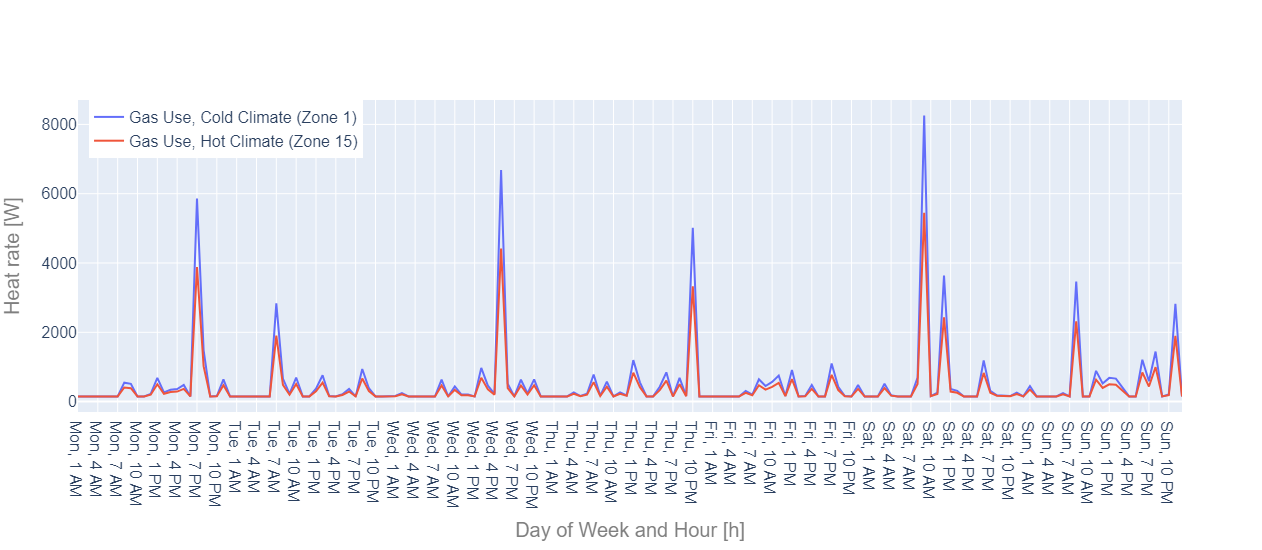

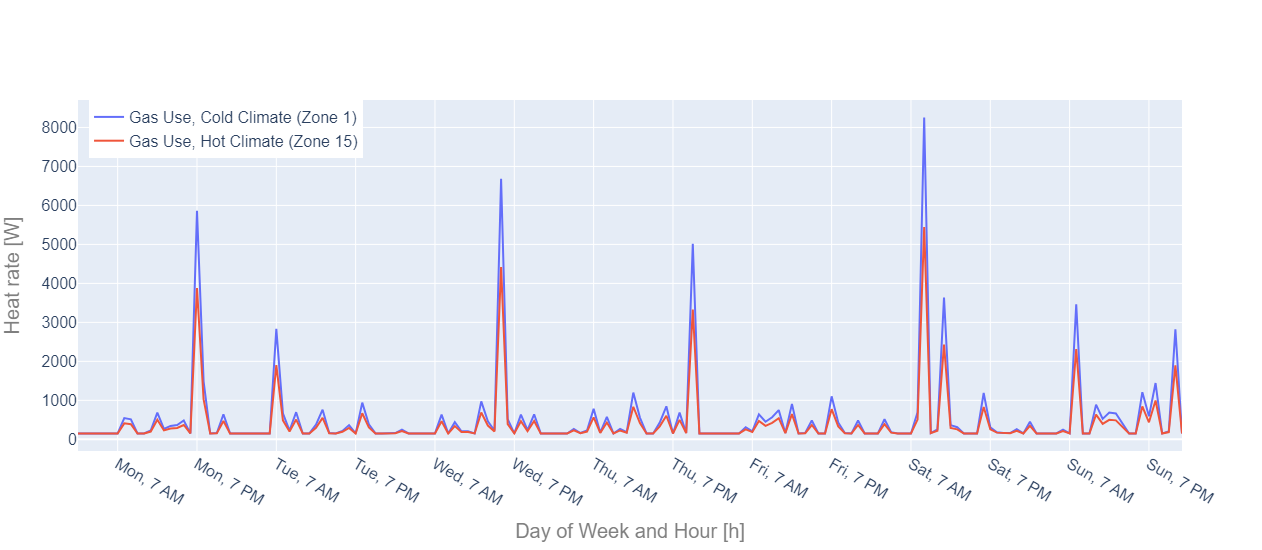

In [103]:
data_bc = pd.DataFrame(data = \
        [ts_proj_cold[r['gas_use']], \
         ts_proj_hot[r['gas_use']]]).transpose()

# data_bc['day_of_week']= calendar_df['day_of_week'].str[:3] + ', h ' + calendar_df['hour'].astype(str)

data_bc['day_of_week']= calendar_df['day_of_week'].str[:3] + ', ' + calendar_df['am_pm']

# fig = Plot(data_headers = ['Gas Use, Cold Climate (Zone '+str(int(cold_cz))+')','Gas Use, Hot Climate (Zone '+hot_cz+')'], \
#                  outpath = '', save_image = False, title = '', label_h = 'Hour [h]', label_v = 'Heat rate [W]',\
#                  legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
#                  notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.01, legend_y = 1.).\
#             series(data_bc[first_hour: last_hour], outfile = '', index_in_a_column = None, modes = 'lines')

fig = Plot(data_headers = ['Gas Use, Cold Climate (Zone '+str(int(cold_cz))+')','Gas Use, Hot Climate (Zone '+hot_cz+')'], \
                 outpath = r'G:\My Drive\Projects\swh\reports\figures\test', save_image = False, title = '', label_h = 'Day of Week and Hour [h]', label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.01, legend_y = 1.).\
            series(data_bc[first_hour: last_hour], outfile = 'test.png', index_in_a_column = 'day_of_week', modes = 'lines')

# fig.update_xaxes(dtick=12)

# Generate tick values based on the spacing
tickvals = data_bc['day_of_week'].unique()[6::12]

# Update x-axis to display the selected ticks
fig.update_xaxes(tickvals=tickvals)

# Show the plot
fig.show()

In [74]:
calendar_df['day_of_week'][:3]

0    Monday
1    Monday
2    Monday
Name: day_of_week, dtype: object

In [50]:
calendar_df['day_of_week'][first_hour: last_hour].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

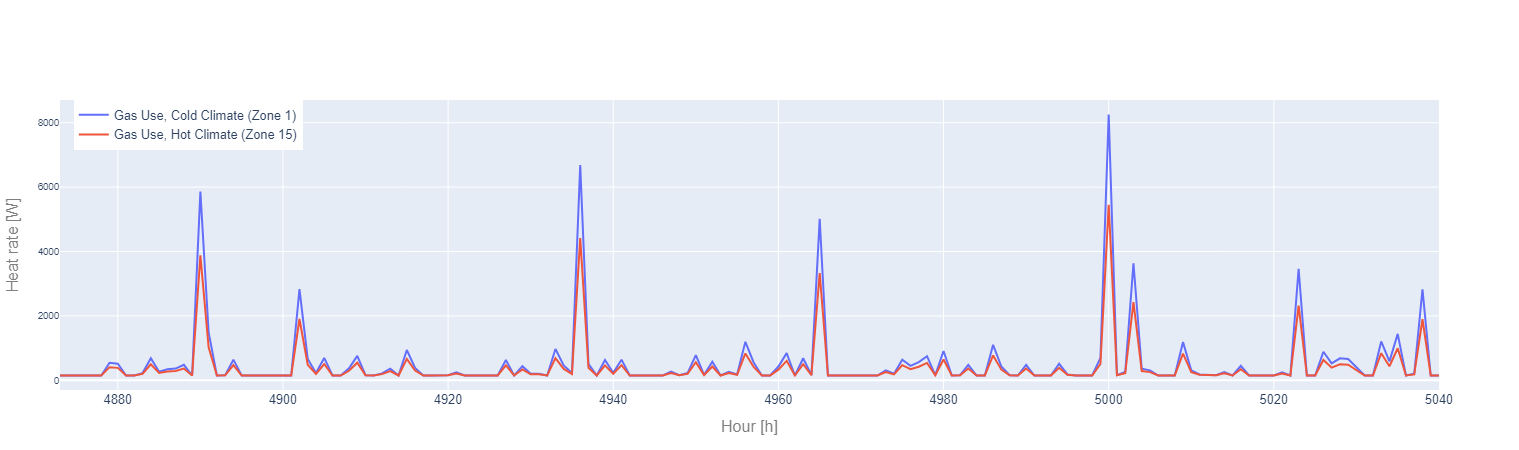

In [34]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
# fig.show()
iplot(fig)

## Individual new solar thermal system

In [37]:
# in a cold climate
sol_wh_indiv_new_cold = System(sys_params = sol_the_sys_params_indiv,
                          backup_params = gas_tankless_wh_params,
                          sys_sizes = sys_sizes_indiv,
                          backup_sizes = new_bckp_size_ind,
                          weather = weather_cold,
                          loads = loads_indiv)

cons_total_indiv_new_cold, proj_total_indiv_new_cold,\
[proj_total_dict_indiv_new_cold, sol_fra_indiv_new_cold, pump_el_use_indiv_new_cold,\
 pump_op_hour_indiv_new_cold, ts_res_indiv_new_cold, backup_ts_cons_indiv_new_cold, rel_err_indiv_new_cold] = \
    sol_wh_indiv_new_cold.solar_thermal(backup = 'gas')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Assigned weather data timeseries.
C:\mg\code\repos\public\MSWH\mswh\system\models.py:574: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [38]:
print('month, day, hour:\nData starts at', ts_res_indiv_new_cold.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_indiv_new_cold.loc[last_hour, ['month','day', 'hour']].transpose().values)

# title = 'Individual SWH New' + ', Climate Zone ' + str(int(cold_cz))

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = '', 
                 label_h = 'Hour [h]', label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.05, legend_y = 1.4).\
            series(ts_res_indiv_new_cold.loc[first_hour : last_hour,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


In [39]:
ts_res_indiv_new_cold.keys()

Index(['Net Heat Demand', 'Heat Demand With Dist. Loss',
       'Demand Balancing Error (Heat Rate)', 'Solar Heat Delivered To Tank',
       'Heat Loss - Lower Tank Volume', 'Heat Loss - Upper Tank Volume',
       'Tank Heat Delivered', 'Tank Unmet Heat', 'Dumped Heat',
       'Tank Overcool (Heat Rate)', 'Temperature - Upper Tank Volume',
       'Temperature - Lower Tank Volume', 'Temperature - Tank Coil Out',
       'Temperature - Hot Water Set', 'Temperature Drop in Distribution Pipes',
       'Distribution Heat Loss', 'Distribution Heat Loss at Backup',
       'Distribution Heat Loss at Backup, Summer',
       'Distribution Heat Loss at Backup, Winter', 'Backup Heat Delivered',
       'Energy Use - Gas', 'Energy Use - Gas, Summer',
       'Energy Use - Gas, Winter', 'Energy Use - Gas, w/o Dist Loss',
       'Energy Use - Gas, Summer, w/o Dist Loss',
       'Energy Use - Gas, Winter, w/o Dist Loss', 'Unmet Heat',
       'Total Heat Delivered', 'Temperature - Ambient',
       'Temper

In [40]:
fig = Plot(data_headers = [r['t_tank_up'], r['t_tank_low']], \
                 outpath = '', save_image = False, title = 'Individual SWH New, Climate Zone ' + str(int(cold_cz)), 
                 label_h = 'Hour [h]', label_v = 'Temperature [K]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.01, legend_y = 1.15).\
            series(ts_res_indiv_new_cold.loc[first_hour + 1 : last_hour + 1,\
                [r['t_tank_up'], r['t_tank_low']]], \
                 outfile = '', modes = 'lines')

In [41]:
# in a hot climate
sol_wh_indiv_new_hot = System(sys_params = sol_the_sys_params_indiv, \
                          backup_params = gas_tankless_wh_params, \
                          sys_sizes = sys_sizes_indiv, \
                          backup_sizes = new_bckp_size_ind, \
                          weather = weather_hot, \
                          loads = loads_indiv)

cons_total_indiv_new_hot, proj_total_indiv_new_hot,\
[proj_total_dict_indiv_new_hot, sol_fra_indiv_new_hot, pump_el_use_indiv_new_hot,\
 pump_op_hour_indiv_new_hot, ts_res_indiv_new_hot, backup_ts_cons_indiv_new_hot, rel_err_indiv_new_hot] = \
    sol_wh_indiv_new_hot.solar_thermal(backup = 'gas')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Assigned weather data timeseries.
C:\mg\code\repos\public\MSWH\mswh\system\models.py:574: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [42]:
# first_hour = 4897
# last_hour = 4897 + 5*24

print('month, day, hour:\nData starts at', ts_res_indiv_new_hot.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_indiv_new_cold.loc[last_hour, ['month','day', 'hour']].transpose().values)

# title = 'Individual SWH New, Climate Zone ' + str(int(hot_cz))

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = '', 
                 label_h = 'Hour [h]', label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.02, legend_y = 1.4).\
            series(ts_res_indiv_new_hot.loc[first_hour + 1 : last_hour + 1,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


In [43]:
# title = 'Individual SWH New, Climate Zone ' + str(int(hot_cz))

fig = Plot(data_headers = [r['t_tank_up'], r['t_tank_low']], \
                 outpath = '', save_image = False, title = '', label_v = 'Temperature [K]',\
                 label_h = 'Hour [h]', legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.05, legend_y = 1.3).\
            series(ts_res_indiv_new_hot.loc[first_hour + 1 : last_hour + 1,\
                [r['t_tank_up'], r['t_tank_low']]], \
                 outfile = '', modes = 'lines')

### Compare individual new system annual totals for two climates

In [41]:
# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(proj_total_indiv_new_cold)
df = df.transpose()
df.index = ['Individual SWH, New, Cold Climate Zone ' + cold_cz]
df1 = pd.DataFrame(proj_total_indiv_new_hot)
df1 = df1.transpose()
df1.index = ['Individual SWH, New, Hot Climate Zone ' + hot_cz]
compare_indiv_new = df.append(df1).transpose()
compare_indiv_new/1000

Individual SWH, New, Cold Climate Zone 01  \
Net Heat Demand                                                           2,425.224   
Heat Demand With Dist. Loss                                               2,425.224   
Demand Balancing Error (Heat Rate)                                            0.000   
Solar Heat Delivered To Tank                                              2,840.269   
Heat Loss - Lower Tank Volume                                               187.498   
Heat Loss - Upper Tank Volume                                               203.633   
Tank Heat Delivered                                                       2,024.730   
Tank Unmet Heat                                                             400.494   
Dumped Heat                                                                 421.987   
Tank Overcool (Heat Rate)                                                     0.009   
Temperature - Upper Tank Volume                                               0.322   
Temperature - Lower Tank Volume                                               0.319   
Temperature - Tank Coil Out                                                   0.321   
Temperature - Hot Water Set                                                   0.322   
Temperature Drop in Distribution Pipes                                        0.000   
Distribution Heat Loss                                                        0.000   
Distribution Heat Loss at Backup                                              0.000   
Distribution Heat Loss at Backup, Summer                                      0.000   
Distribution Heat Loss at Backup, Winter                                      0.000   
Backup Heat Delivered                                                       400.494   
Energy Use - Gas                                                            471.170   
Energy Use - Gas, Summer                                                     65.169   
Energy Use - Gas, Winter                                                    406.000   
Energy Use - Gas, w/o Dist Loss                                             471.170   
Energy Use - Gas, Summer, w/o Dist Loss                                      65.169   
Energy Use - Gas, Winter, w/o Dist Loss                                     406.000   
Unmet Heat                                                                    0.000   
Total Heat Delivered                                                      2,425.224   
Temperature - Ambient                                                         0.284   
Temperature - Water Main                                                      0.283   
Project End-Use Load                                                          0.000   
Energy Use - Electricity                                                     45.423   
Energy Use - Electricity, Summer                                             21.372   
Energy Use - Electricity, Winter                                             24.051   
Solar Fraction                                                                0.001   
Peak End-Use Load [gal]                                                       0.042   

                                          Individual SWH, New, Hot Climate Zone 15  
Net Heat Demand                                                          1,737.256  
Heat Demand With Dist. Loss                                              1,737.256  
Demand Balancing Error (Heat Rate)                                           0.000  
Solar Heat Delivered To Tank                                             4,589.625  
Heat Loss - Lower Tank Volume                                              198.007  
Heat Loss - Upper Tank Volume                                              212.973  
Tank Heat Delivered                                                      1,705.425  
Tank Unmet Heat                                                             31.832  
Dumped Heat                                              

In [42]:
pd.options.display.float_format = '{:,.0f}'.format
# subset of results for the report
(compare_indiv_new.loc[["Net Heat Demand",
'Heat Demand With Dist. Loss',
'Solar Heat Delivered To Tank',
'Tank Heat Delivered',
'Tank Unmet Heat',
'Dumped Heat',
'Distribution Heat Loss',
'Backup Heat Delivered',
'Energy Use - Gas',
'Energy Use - Gas, Summer',
'Energy Use - Gas, Winter',
'Unmet Heat',
'Total Heat Delivered',
'Energy Use - Electricity',
'Energy Use - Electricity, Summer',
'Energy Use - Electricity, Winter',
'Solar Fraction',
'Peak End-Use Load [gal]'],:]/1000).round(0).to_clipboard()

## Community new solar thermal system

In [43]:
# in a cold climate
sol_wh_com_new_cold = System(sys_params = sol_the_sys_params_com,
                          backup_params = gas_tankless_wh_params,
                          sys_sizes = sys_sizes_com,
                          backup_sizes = new_bckp_size_com,
                          weather = weather_cold,
                          loads = loads_com)

cons_total_com_new_cold, proj_total_com_new_cold,\
[proj_total_dict_com_new_cold, sol_fra_com_new_cold, pump_el_use_com_new_cold,\
 pump_op_hour_com_new_cold, ts_res_com_new_cold, backup_ts_cons_com_new_cold, rel_err_com_new_cold] = \
    sol_wh_com_new_cold.solar_thermal(backup = 'gas')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.


month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


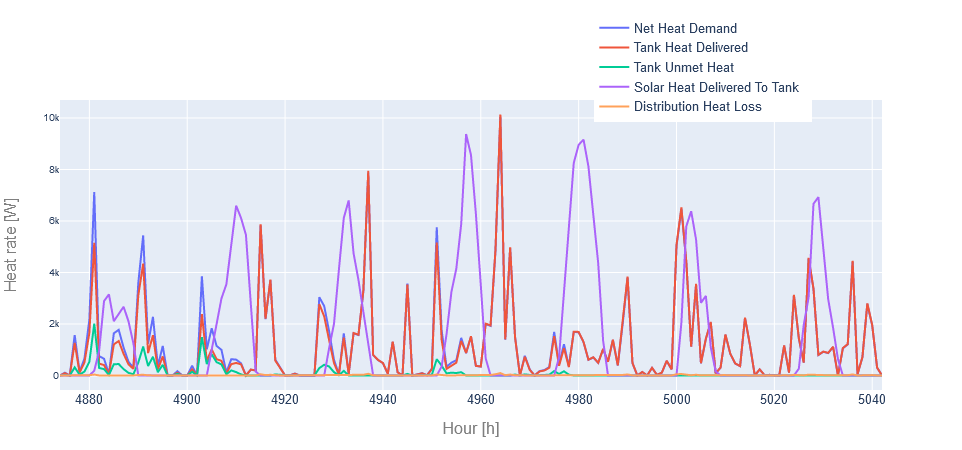

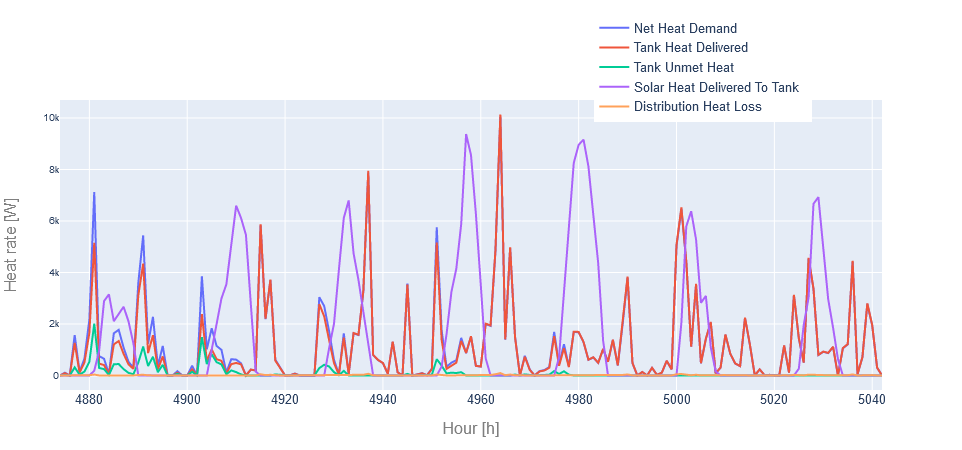

In [44]:
# first_hour = 4897
# last_hour = 4897 + 5*24

print('month, day, hour:\nData starts at', ts_res_com_new_cold.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_com_new_cold.loc[last_hour, ['month','day', 'hour']].transpose().values)

# title = 'Community SWH New, Climate Zone ' + str(int(cold_cz))

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = '', 
                 label_h = 'Hour [h]', label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.65, legend_y = 1.3).\
            series(ts_res_com_new_cold.loc[first_hour + 1 : last_hour + 1,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

fig.show()

In [45]:
# in a hot climate
sol_wh_com_new_hot = System(sys_params = sol_the_sys_params_com,
                          backup_params = gas_tankless_wh_params,
                          sys_sizes = sys_sizes_com,
                          backup_sizes = new_bckp_size_com,
                          weather = weather_hot,
                          loads = loads_com)

cons_total_com_new_hot, proj_total_com_new_hot,\
[proj_total_dict_com_new_hot, sol_fra_com_new_hot, pump_el_use_com_new_hot,\
 pump_op_hour_com_new_hot, ts_res_com_new_hot, backup_ts_cons_com_new_hot, rel_err_com_new_hot] = \
    sol_wh_com_new_hot.solar_thermal(backup = 'gas')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.


month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


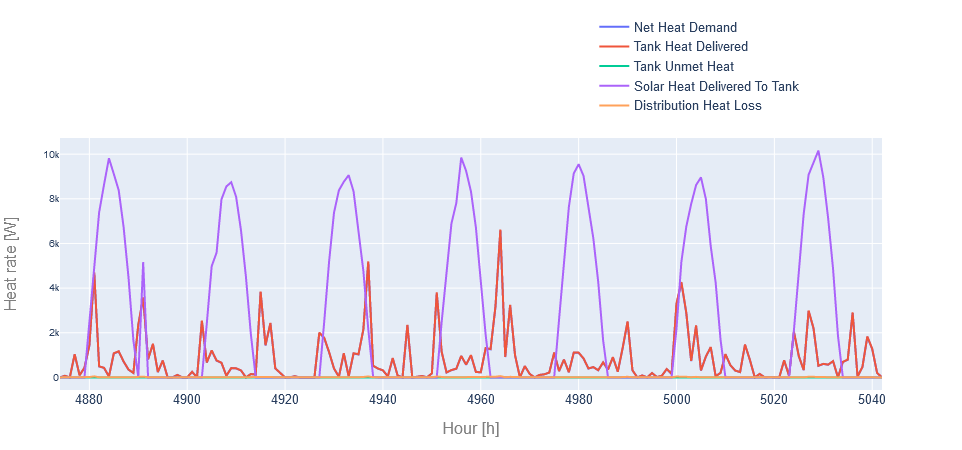

In [46]:
print('month, day, hour:\nData starts at', ts_res_com_new_hot.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_com_new_hot.loc[last_hour, ['month','day', 'hour']].transpose().values)

# title = 'Community SWH New, Climate Zone ' + str(int(cold_cz))

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = '', 
                 label_h = 'Hour [h]', label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False,margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.65, legend_y = 1.5).\
            series(ts_res_com_new_hot.loc[first_hour + 1 : last_hour + 1,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

### Compare community new system annual totals for two climates

In [47]:
# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(proj_total_com_new_cold)
df = df.transpose()
df.index = ['Community SWH, New, Cold Climate Zone ' + cold_cz]
df1 = pd.DataFrame(proj_total_com_new_hot)
df1 = df1.transpose()
df1.index = ['Community SWH, New, Hot Climate Zone ' + hot_cz]
compare_com_new = df.append(df1).transpose()
compare_com_new

Community SWH, New, Cold Climate Zone 01  \
Net Heat Demand                                                          9,633,432   
Heat Demand With Dist. Loss                                              9,708,428   
Demand Balancing Error (Heat Rate)                                               0   
Solar Heat Delivered To Tank                                            10,993,628   
Heat Loss - Lower Tank Volume                                              498,986   
Heat Loss - Upper Tank Volume                                              528,581   
Tank Heat Delivered                                                      8,271,488   
Tank Unmet Heat                                                          1,436,940   
Dumped Heat                                                              1,684,028   
Tank Overcool (Heat Rate)                                                       24   
Temperature - Upper Tank Volume                                                323   
Temperature - Lower Tank Volume                                                321   
Temperature - Tank Coil Out                                                    323   
Temperature - Hot Water Set                                                    322   
Temperature Drop in Distribution Pipes                                           0   
Distribution Heat Loss                                                      74,997   
Distribution Heat Loss at Backup                                            19,652   
Distribution Heat Loss at Backup, Summer                                     5,366   
Distribution Heat Loss at Backup, Winter                                    14,286   
Backup Heat Delivered                                                    1,436,940   
Energy Use - Gas                                                         1,690,517   
Energy Use - Gas, Summer                                                   231,095   
Energy Use - Gas, Winter                                                 1,459,423   
Energy Use - Gas, w/o Dist Loss                                          1,667,397   
Energy Use - Gas, Summer, w/o Dist Loss                                    224,781   
Energy Use - Gas, Winter, w/o Dist Loss                                  1,442,616   
Unmet Heat                                                                       0   
Total Heat Delivered                                                     9,708,428   
Temperature - Ambient                                                          284   
Temperature - Water Main                                                       283   
Project End-Use Load                                                             0   
Energy Use - Electricity                                                   116,678   
Energy Use - Electricity, Summer                                            54,642   
Energy Use - Electricity, Winter                                            62,036   
Solar Fraction                                                                   1   
Peak End-Use Load [gal]                                                         81   

                                          Community SWH, New, Hot Climate Zone 15  
Net Heat Demand                                                         6,899,778  
Heat Demand With Dist. Loss                                             6,976,292  
Demand Balancing Error (Heat Rate)                                              0  
Solar Heat Delivered To Tank                                           18,159,028  
Heat Loss - Lower Tank Volume                                             512,103  
Heat Loss - Upper Tank Volume                                             541,248  
Tank Heat Delivered                                                     6,888,248  
Tank Unmet Heat                                                            88,043  
Dumped Heat                                                            10,184,794  
Tank Overcool (Heat

In [48]:
# pd.options.display.float_format = '{:,.0f}'.format
# subset of results for the report
(compare_com_new.loc[["Net Heat Demand",
'Heat Demand With Dist. Loss',
'Solar Heat Delivered To Tank',
'Tank Heat Delivered',
'Tank Unmet Heat',
'Dumped Heat',
'Distribution Heat Loss',
'Backup Heat Delivered',
'Energy Use - Gas',
'Energy Use - Gas, Summer',
'Energy Use - Gas, Winter',
'Energy Use - Gas, w/o Dist Loss',
'Unmet Heat',
'Total Heat Delivered',
'Energy Use - Electricity',
'Energy Use - Electricity, Summer',
'Energy Use - Electricity, Winter',
'Solar Fraction',
'Peak End-Use Load [gal]'],:]/1000).round(0)#.to_clipboard()

Community SWH, New, Cold Climate Zone 01  \
Net Heat Demand                                                      9,633   
Heat Demand With Dist. Loss                                          9,708   
Solar Heat Delivered To Tank                                        10,994   
Tank Heat Delivered                                                  8,271   
Tank Unmet Heat                                                      1,437   
Dumped Heat                                                          1,684   
Distribution Heat Loss                                                  75   
Backup Heat Delivered                                                1,437   
Energy Use - Gas                                                     1,691   
Energy Use - Gas, Summer                                               231   
Energy Use - Gas, Winter                                             1,459   
Energy Use - Gas, w/o Dist Loss                                      1,667   
Unmet Heat                                                               0   
Total Heat Delivered                                                 9,708   
Energy Use - Electricity                                               117   
Energy Use - Electricity, Summer                                        55   
Energy Use - Electricity, Winter                                        62   
Solar Fraction                                                           0   
Peak End-Use Load [gal]                                                  0   

                                  Community SWH, New, Hot Climate Zone 15  
Net Heat Demand                                                     6,900  
Heat Demand With Dist. Loss                                         6,976  
Solar Heat Delivered To Tank                                       18,159  
Tank Heat Delivered                                                 6,888  
Tank Unmet Heat                                                        88  
Dumped Heat                                                        10,185  
Distribution Heat Loss                                                 77  
Backup Heat Delivered                                                  88  
Energy Use - Gas                                                      104  
Energy Use - Gas, Summer                                                0  
Energy Use - Gas, Winter                                              104  
Energy Use - Gas, w/o Dist Loss                                       101  
Unmet Heat                                                              0  
Total Heat Delivered                                                6,976  
Energy Use - Electricity                                              133  
Energy Use - Electricity, Summer                                       61  
Energy Use - Electricity, Winter                                       73  
Solar Fraction                                                          0  
Peak End-Use Load [gal]                                                 0

In [49]:
cons_total_com_new_cold["Solar Fraction"].round(3)

0   1
1   1
2   1
3   1
Name: Solar Fraction, dtype: float64

In [50]:
# Project level total vs. individual household total
print(abs(cons_total_com_new_hot["Energy Use - Gas"].sum() -
                    proj_total_com_new_hot["Energy Use - Gas"]).round(2))

print(abs(cons_total_com_new_hot["Tank Heat Delivered"].sum() -
                    proj_total_com_new_hot["Tank Heat Delivered"]).round(2))

0.0
0.0


### Compare new installation systems across climates and scales

In [51]:
# for cold climate

# Energy use per household
com = cons_total_com_new_cold.sum()/4
ind = cons_total_indiv_new_cold.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Per Household, Community, New, Cold Climate Zone ' + cold_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['Individual, New, Cold Climate Zone ' + cold_cz]
compare_cold = df.append(df1).transpose()

# for hot climate

# Energy use per household
com = cons_total_com_new_hot.sum()/4
ind = cons_total_indiv_new_hot.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Per Household, Community, New, Hot Climate Zone ' + hot_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['Individual, New, Hot Climate Zone ' + hot_cz]
compare_hot = df.append(df1).transpose()
compare = compare_cold.copy()
compare[compare_hot.columns] = compare_hot

compare

Per Household, Community, New, Cold Climate Zone 01  \
Consumer ID                                                                               2     
Occupancy                                                                                 3     
Energy Use - Gas                                                                    422,629     
Energy Use - Gas, Summer                                                             57,774     
Energy Use - Gas, Winter                                                            364,856     
Energy Use - Electricity                                                             29,169     
Energy Use - Electricity, Summer                                                     13,661     
Energy Use - Electricity, Winter                                                     15,509     
Solar Fraction                                                                            1     
Backup Heat Delivered                                                               359,235     
Unmet Heat                                                                                0     
Energy Use - Gas, w/o Dist Loss                                                     416,849     
Energy Use - Gas, Summer, w/o Dist Loss                                              56,195     
Energy Use - Gas, Winter, w/o Dist Loss                                             360,654     
Net Heat Demand                                                                   2,408,358     
Total Heat Delivered                                                              2,427,107     
Tank Unmet Heat                                                                     359,235     
Tank Heat Delivered                                                               2,067,872     
Distribution Heat Loss                                                               18,749     
Distribution Heat Loss at Backup                                                      4,913     
Distribution Heat Loss at Backup, Winter                                              3,571     
Distribution Heat Loss at Backup, Summer                                              1,342     

                                          Individual, New, Cold Climate Zone 01  \
Consumer ID                                                                   1   
Occupancy                                                                     3   
Energy Use - Gas                                                        471,170   
Energy Use - Gas, Summer                                                 65,169   
Energy Use - Gas, Winter                                                406,000   
Energy Use - Electricity                                                 45,423   
Energy Use - Electricity, Summer                                         21,372   
Energy Use - Electricity, Winter                                         24,051   
Solar Fraction                                                                1   
Backup Heat Delivered                                                   400,494   
Unmet Heat                                                                    0   
Energy Use - Gas, w/o Dist Loss                                         471,170   
Energy Use - Gas, Summer, w/o Dist Loss                                  65,169   
Energy Use - Gas, Winter, w/o Dist Loss                                 406,000   
Net Heat Demand                                                       2,425,224   
Total Heat Delivered                                                  2,425,224   
Tank Unmet Heat                                                         400,494   
Tank Heat Delivered                                                   2,024,730   
Distribution Heat Loss                                                        0   
Distribution Heat Loss at Backup                                              0   
Distribution Heat Loss at Backup, Winter                           

In [52]:
pd.options.display.float_format = '{:,.0f}'.format
# subset of results for the report
(compare.loc[['Energy Use - Gas',
'Energy Use - Gas, Summer',
'Energy Use - Gas, Winter',
'Energy Use - Gas, w/o Dist Loss',
'Energy Use - Electricity',
'Solar Fraction',
'Backup Heat Delivered',
'Unmet Heat',
'Net Heat Demand',
'Total Heat Delivered',
'Tank Unmet Heat',
'Tank Heat Delivered',
'Distribution Heat Loss'
],:]/1000).round(0)#.to_clipboard()

Per Household, Community, New, Cold Climate Zone 01  \
Energy Use - Gas                                                               423     
Energy Use - Gas, Summer                                                        58     
Energy Use - Gas, Winter                                                       365     
Energy Use - Gas, w/o Dist Loss                                                417     
Energy Use - Electricity                                                        29     
Solar Fraction                                                                   0     
Backup Heat Delivered                                                          359     
Unmet Heat                                                                       0     
Net Heat Demand                                                              2,408     
Total Heat Delivered                                                         2,427     
Tank Unmet Heat                                                                359     
Tank Heat Delivered                                                          2,068     
Distribution Heat Loss                                                          19     

                                 Individual, New, Cold Climate Zone 01  \
Energy Use - Gas                                                   471   
Energy Use - Gas, Summer                                            65   
Energy Use - Gas, Winter                                           406   
Energy Use - Gas, w/o Dist Loss                                    471   
Energy Use - Electricity                                            45   
Solar Fraction                                                       0   
Backup Heat Delivered                                              400   
Unmet Heat                                                           0   
Net Heat Demand                                                  2,425   
Total Heat Delivered                                             2,425   
Tank Unmet Heat                                                    400   
Tank Heat Delivered                                              2,025   
Distribution Heat Loss                                               0   

                                 Per Household, Community, New, Hot Climate Zone 15  \
Energy Use - Gas                                                                26    
Energy Use - Gas, Summer                                                         0    
Energy Use - Gas, Winter                                                        26    
Energy Use - Gas, w/o Dist Loss                                                 25    
Energy Use - Electricity                                                        33    
Solar Fraction                                                                   0    
Backup Heat Delivered                                                           22    
Unmet Heat                                                                       0    
Net Heat Demand                                                              1,725    
Total Heat Delivered                                                         1,744    
Tank Unmet Heat                                                                 22    
Tank Heat Delivered                                                          1,722    
Distribution Heat Loss                                                          19    

                                 Individual, New, Hot Climate Zone 15  
Energy Use - Gas                                                   37  
Energy Use - Gas, Summer                                            0  
Energy Use - Gas, Winter                                           37  
Energy Use - Gas, w/o Dist Loss                                    37  
Energy Use - Electricity                                           53  
Solar Fraction                                                      0  
Backup Heat Delivered                   

## Individual retrofit solar thermal system

In [53]:
# in a cold climate
sol_wh_indiv_retrofit_cold = System(sys_params = sol_the_sys_params_indiv,
                          backup_params = gas_tank_wh_params,
                          sys_sizes = sys_sizes_indiv,
                          backup_sizes = retrofit_bckp_size_indiv,
                          weather = weather_cold,
                          loads = loads_indiv)

cons_total_indiv_retrofit_cold, proj_total_indiv_retrofit_cold,\
[proj_total_dict_indiv_retrofit_cold, sol_fra_indiv_retrofit_cold, pump_el_use_indiv_retrofit_cold,\
 pump_op_hour_indiv_retrofit_cold, ts_res_indiv_retrofit_cold, backup_ts_cons_indiv_retrofit_cold, rel_err_indiv_retrofit_cold] = \
    sol_wh_indiv_retrofit_cold.solar_thermal(backup = 'retrofit')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.


month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


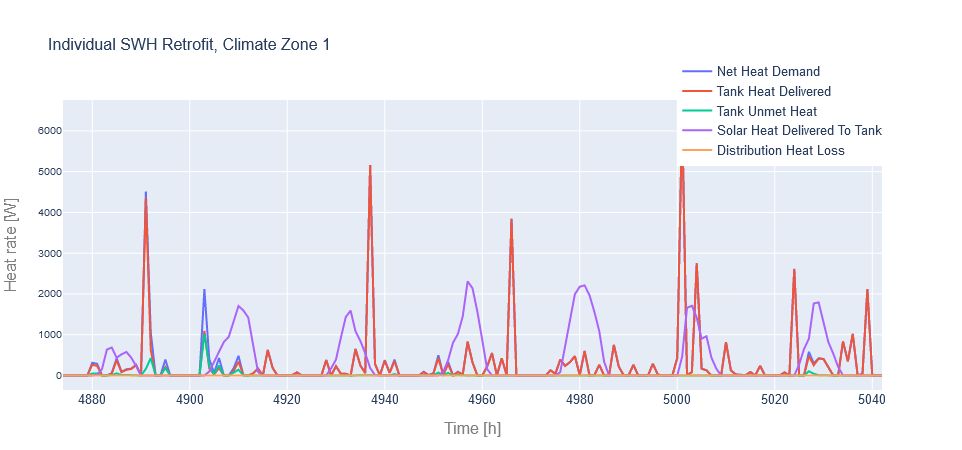

In [54]:
print('month, day, hour:\nData starts at', ts_res_indiv_retrofit_cold.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_indiv_retrofit_cold.loc[last_hour, ['month','day', 'hour']].transpose().values)

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = 'Individual SWH Retrofit' + ', Climate Zone ' + str(int(cold_cz)),
                 label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.75, legend_y = 1.15).\
            series(ts_res_indiv_retrofit_cold.loc[first_hour + 1 : last_hour + 1,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

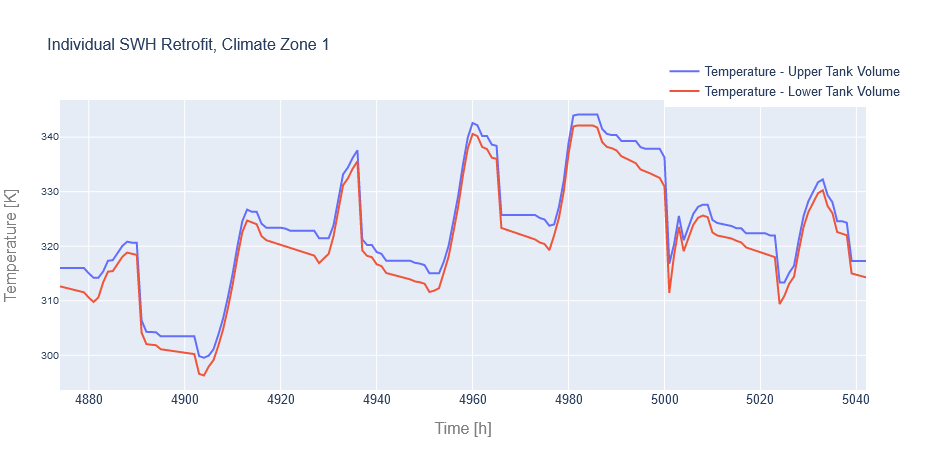

In [55]:
fig = Plot(data_headers = [r['t_tank_up'], r['t_tank_low']], \
                 outpath = '', save_image = False, title = 'Individual SWH Retrofit' + ', Climate Zone ' + str(int(cold_cz)), label_v = 'Temperature [K]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.75, legend_y = 1.15).\
            series(ts_res_indiv_retrofit_cold.loc[first_hour + 1 : last_hour + 1,\
                [r['t_tank_up'], r['t_tank_low']]], \
                 outfile = '', modes = 'lines')

In [56]:
# in a hot climate
sol_wh_indiv_retrofit_hot = System(sys_params = sol_the_sys_params_indiv,
                          backup_params = gas_tank_wh_params,
                          sys_sizes = sys_sizes_indiv,
                          backup_sizes = retrofit_bckp_size_indiv,
                          weather = weather_hot,
                          loads = loads_indiv)

cons_total_indiv_retrofit_hot, proj_total_indiv_retrofit_hot,\
[proj_total_dict_indiv_retrofit_hot, sol_fra_indiv_retrofit_hot, pump_el_use_indiv_retrofit_hot,\
 pump_op_hour_indiv_retrofit_hot, ts_res_indiv_retrofit_hot, backup_ts_cons_indiv_retrofit_hot, rel_err_indiv_retrofit_hot] = \
    sol_wh_indiv_retrofit_hot.solar_thermal(backup = 'retrofit')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.


month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


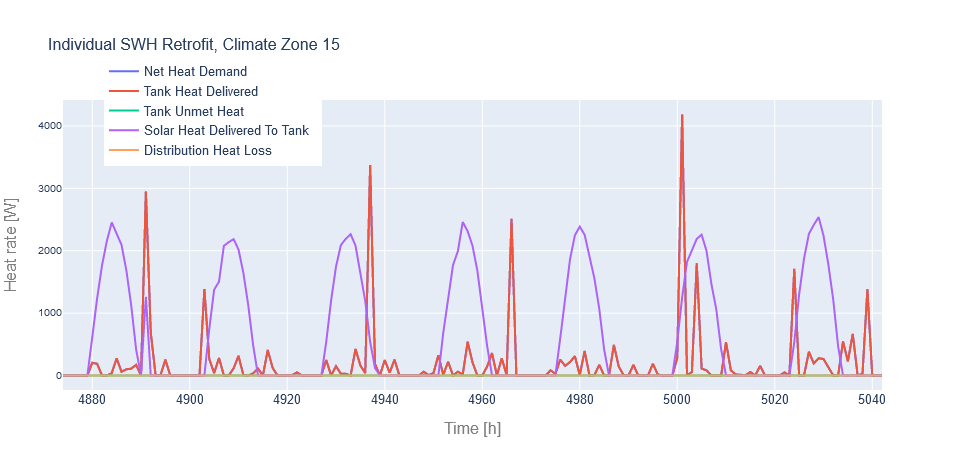

In [57]:
print('month, day, hour:\nData starts at', ts_res_indiv_retrofit_hot.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_indiv_retrofit_hot.loc[last_hour, ['month','day', 'hour']].transpose().values)

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = 'Individual SWH Retrofit' + ', Climate Zone ' + str(int(hot_cz)), label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.05, legend_y = 1.15).\
            series(ts_res_indiv_retrofit_hot.loc[first_hour + 1 : last_hour + 1,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

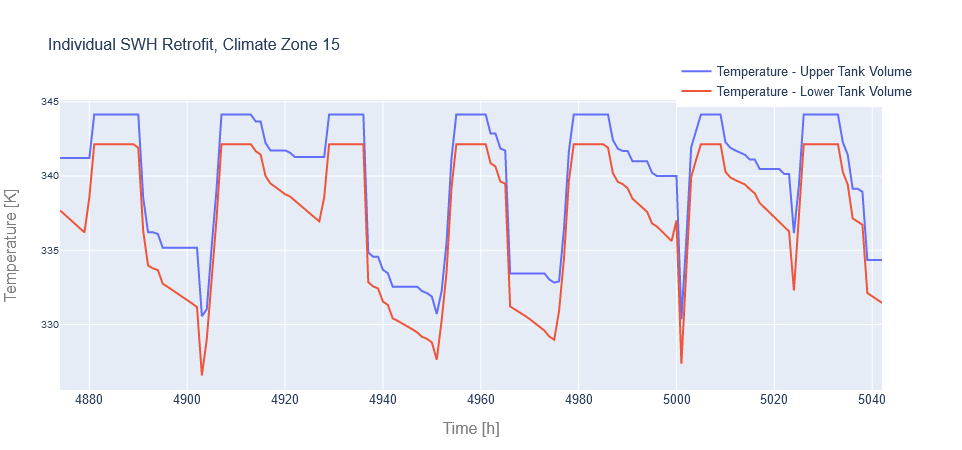

In [58]:
fig = Plot(data_headers = [r['t_tank_up'], r['t_tank_low']], \
                 outpath = '', save_image = False, title = 'Individual SWH Retrofit' + ', Climate Zone ' + str(int(hot_cz)), label_v = 'Temperature [K]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.75, legend_y = 1.15).\
            series(ts_res_indiv_retrofit_hot.loc[first_hour + 1 : last_hour + 1,\
                [r['t_tank_up'], r['t_tank_low']]], \
                 outfile = '', modes = 'lines')

### Compare individual retrofit system annual totals for two climates

In [59]:
# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(proj_total_indiv_retrofit_cold)
df = df.transpose()
df.index = ['Individual SWH, Retrofit, Cold Climate Zone ' + cold_cz]
df1 = pd.DataFrame(proj_total_indiv_retrofit_hot)
df1 = df1.transpose()
df1.index = ['Individual SWH, Retrofit, Cold Climate Zone ' + hot_cz]
compare_indiv_retrofit = df.append(df1).transpose()
compare_indiv_retrofit

Individual SWH, Retrofit, Cold Climate Zone 01  \
Net Heat Demand                                                                2,425,224   
Heat Demand With Dist. Loss                                                    2,425,224   
Demand Balancing Error (Heat Rate)                                                     0   
Solar Heat Delivered To Tank                                                   2,840,269   
Heat Loss - Lower Tank Volume                                                    187,498   
Heat Loss - Upper Tank Volume                                                    203,633   
Tank Heat Delivered                                                            2,024,730   
Tank Unmet Heat                                                                  400,494   
Dumped Heat                                                                      421,987   
Tank Overcool (Heat Rate)                                                              9   
Temperature - Upper Tank Volume                                                      322   
Temperature - Lower Tank Volume                                                      319   
Temperature - Tank Coil Out                                                          321   
Temperature - Hot Water Set                                                          322   
Temperature Drop in Distribution Pipes                                                 0   
Distribution Heat Loss                                                                 0   
Distribution Heat Loss at Backup                                                       0   
Distribution Heat Loss at Backup, Summer                                               0   
Distribution Heat Loss at Backup, Winter                                               0   
Backup Heat Delivered                                                            400,497   
Energy Use - Gas                                                               1,824,377   
Energy Use - Gas, Summer                                                         622,288   
Energy Use - Gas, Winter                                                       1,202,089   
Energy Use - Gas, w/o Dist Loss                                                1,824,377   
Energy Use - Gas, Summer, w/o Dist Loss                                          622,288   
Energy Use - Gas, Winter, w/o Dist Loss                                        1,202,089   
Unmet Heat                                                                             0   
Total Heat Delivered                                                           2,425,227   
Temperature - Ambient                                                                284   
Temperature - Water Main                                                             283   
Project End-Use Load                                                                   0   
Energy Use - Electricity                                                          45,423   
Energy Use - Electricity, Summer                                                  21,372   
Energy Use - Electricity, Winter                                                  24,051   
Solar Fraction                                                                         1   
Peak End-Use Load [gal]                                                               42   

                                          Individual SWH, Retrofit, Cold Climate Zone 15  
Net Heat Demand                                                                1,737,256  
Heat Demand With Dist. Loss                                                    1,737,256  
Demand Balancing Error (Heat Rate)                                                     0  
Solar Heat Delivered To Tank                                                   4,589,625  
Heat Loss - Lower Tank Volume                                                    198,007  
Heat Loss - Upper Tank Volume                                                    212,973  


In [60]:
pd.options.display.float_format = '{:,.0f}'.format
# subset of results for the report
(compare_indiv_retrofit.loc[["Net Heat Demand",
'Heat Demand With Dist. Loss',
'Solar Heat Delivered To Tank',
'Tank Heat Delivered',
'Tank Unmet Heat',
'Dumped Heat',
'Distribution Heat Loss',
'Backup Heat Delivered',
'Energy Use - Gas',
'Energy Use - Gas, Summer',
'Energy Use - Gas, Winter',
'Unmet Heat',
'Total Heat Delivered',
'Energy Use - Electricity',
'Energy Use - Electricity, Summer',
'Energy Use - Electricity, Winter',
'Solar Fraction',
'Peak End-Use Load [gal]'],:]/1000).round(0).to_clipboard()

## Community retrofit solar thermal system

In [61]:
# in a cold climate
sol_wh_com_retrofit_cold = System(sys_params = sol_the_sys_params_com,
                          backup_params = gas_tank_wh_params,
                          sys_sizes = sys_sizes_com,
                          backup_sizes = retrofit_bckp_size_com,
                          weather = weather_cold,
                          loads = loads_com)

cons_total_com_retrofit_cold, proj_total_com_retrofit_cold,\
[proj_total_dict_com_retrofit_cold, sol_fra_com_retrofit_cold, pump_el_use_com_retrofit_cold,\
 pump_op_hour_com_retrofit_cold, ts_res_com_retrofit_cold, backup_ts_cons_com_retrofit_cold, rel_err_com_retrofit_cold] = \
    sol_wh_com_retrofit_cold.solar_thermal(backup = 'retrofit')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.


month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


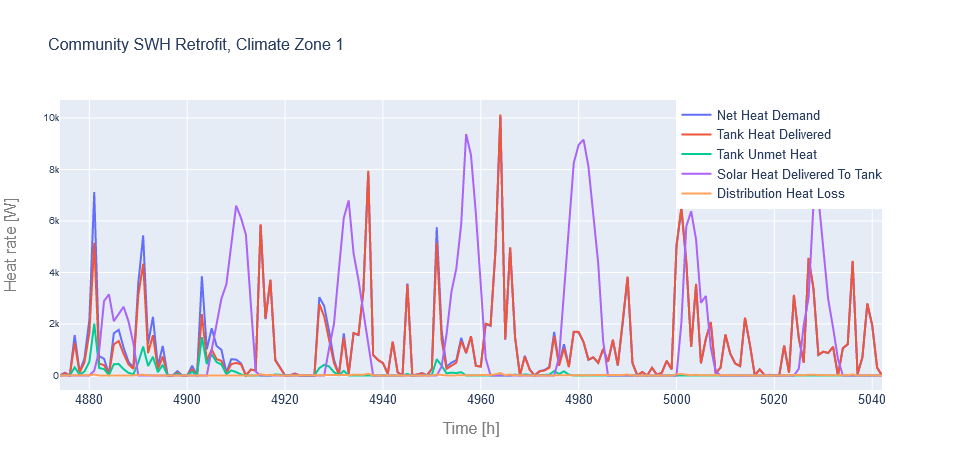

In [62]:
print('month, day, hour:\nData starts at', ts_res_com_retrofit_cold.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_com_retrofit_cold.loc[last_hour, ['month','day', 'hour']].transpose().values)

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = 'Community SWH Retrofit, Climate Zone ' + str(int(cold_cz)), label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.75, legend_y = 1.).\
            series(ts_res_com_retrofit_cold.loc[first_hour + 1 : last_hour + 1,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

In [63]:
# in a hot climate
sol_wh_com_retrofit_hot = System(sys_params = sol_the_sys_params_com,
                          backup_params = gas_tank_wh_params,
                          sys_sizes = sys_sizes_com,
                          backup_sizes = retrofit_bckp_size_com,
                          weather = weather_hot,
                          loads = loads_com)

cons_total_com_retrofit_hot, proj_total_com_retrofit_hot,\
[proj_total_dict_com_retrofit_hot, sol_fra_com_retrofit_hot, pump_el_use_com_retrofit_hot,\
 pump_op_hour_com_retrofit_hot, ts_res_com_retrofit_hot, backup_ts_cons_com_retrofit_hot, rel_err_com_retrofit_hot] = \
    sol_wh_com_retrofit_hot.solar_thermal(backup = 'retrofit')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.


month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


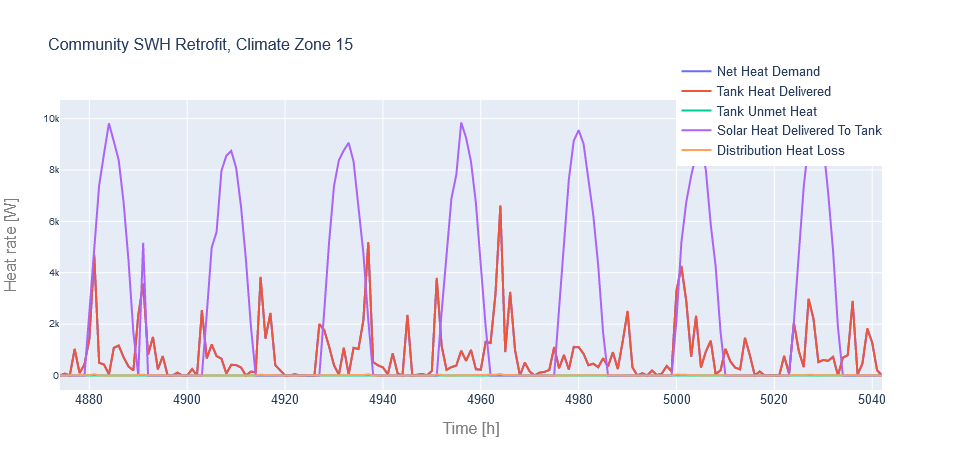

In [64]:
print('month, day, hour:\nData starts at', ts_res_com_retrofit_hot.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_com_retrofit_hot.loc[last_hour, ['month','day', 'hour']].transpose().values)

fig = Plot(data_headers = [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']], \
                 outpath = '', save_image = False, title = 'Community SWH Retrofit, Climate Zone ' + str(int(hot_cz)), label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = False, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = 0.75, legend_y = 1.15).\
            series(ts_res_com_retrofit_hot.loc[first_hour + 1 : last_hour + 1,\
                [r['q_dem'], r['q_del_tank'],r['q_unmet_tank'],r['q_del_sol'],r['q_dist_loss']]], \
                 outfile = '', modes = 'lines')

### Compare community retrofit system annual totals for two climates

In [65]:
# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(proj_total_com_retrofit_cold)
df = df.transpose()
df.index = ['Community SWH, Retrofit, Cold Climate ' + cold_cz]
df1 = pd.DataFrame(proj_total_com_retrofit_hot)
df1 = df1.transpose()
df1.index = ['Community SWH, Retrofit, Hot Climate ' + hot_cz]
compare_community_retrofit = df.append(df1).transpose()
compare_community_retrofit.round(3)

Community SWH, Retrofit, Cold Climate 01  \
Net Heat Demand                                                          9,633,432   
Heat Demand With Dist. Loss                                              9,708,428   
Demand Balancing Error (Heat Rate)                                               0   
Solar Heat Delivered To Tank                                            10,993,628   
Heat Loss - Lower Tank Volume                                              498,986   
Heat Loss - Upper Tank Volume                                              528,581   
Tank Heat Delivered                                                      8,271,488   
Tank Unmet Heat                                                          1,436,940   
Dumped Heat                                                              1,684,028   
Tank Overcool (Heat Rate)                                                       24   
Temperature - Upper Tank Volume                                                323   
Temperature - Lower Tank Volume                                                321   
Temperature - Tank Coil Out                                                    323   
Temperature - Hot Water Set                                                    322   
Temperature Drop in Distribution Pipes                                           0   
Distribution Heat Loss                                                      74,997   
Distribution Heat Loss at Backup                                            19,652   
Distribution Heat Loss at Backup, Summer                                     5,366   
Distribution Heat Loss at Backup, Winter                                    14,286   
Backup Heat Delivered                                                    1,436,104   
Energy Use - Gas                                                         7,097,925   
Energy Use - Gas, Summer                                                 2,461,396   
Energy Use - Gas, Winter                                                 4,636,529   
Energy Use - Gas, w/o Dist Loss                                          7,074,111   
Energy Use - Gas, Summer, w/o Dist Loss                                  2,454,884   
Energy Use - Gas, Winter, w/o Dist Loss                                  4,619,227   
Unmet Heat                                                                       0   
Total Heat Delivered                                                     9,707,592   
Temperature - Ambient                                                          284   
Temperature - Water Main                                                       283   
Project End-Use Load                                                             0   
Energy Use - Electricity                                                   116,678   
Energy Use - Electricity, Summer                                            54,642   
Energy Use - Electricity, Winter                                            62,036   
Solar Fraction                                                                   1   
Peak End-Use Load [gal]                                                         81   

                                          Community SWH, Retrofit, Hot Climate 15  
Net Heat Demand                                                         6,899,778  
Heat Demand With Dist. Loss                                             6,976,292  
Demand Balancing Error (Heat Rate)                                              0  
Solar Heat Delivered To Tank                                           18,159,028  
Heat Loss - Lower Tank Volume                                             512,103  
Heat Loss - Upper Tank Volume                                             541,248  
Tank Heat Delivered                                                     6,888,248  
Tank Unmet Heat                                                            88,043  
Dumped Heat                                                            10,184,794  
Tank Overcool (Heat

In [66]:
cons_total_com_retrofit_cold["Solar Fraction"].round(3)

0   1
1   1
2   1
3   1
Name: Solar Fraction, dtype: float64

In [67]:
pd.options.display.float_format = '{:,.3f}'.format
# subset of results for the report
(compare_community_retrofit.loc[["Net Heat Demand",
'Heat Demand With Dist. Loss',
'Solar Heat Delivered To Tank',
'Tank Heat Delivered',
'Tank Unmet Heat',
'Dumped Heat',
'Distribution Heat Loss',
'Backup Heat Delivered',
'Energy Use - Gas',
'Energy Use - Gas, Summer',
'Energy Use - Gas, Winter',
'Energy Use - Gas, w/o Dist Loss',
'Unmet Heat',
'Total Heat Delivered',
'Energy Use - Electricity',
'Energy Use - Electricity, Summer',
'Energy Use - Electricity, Winter',
'Solar Fraction',
'Peak End-Use Load [gal]'],:]/1000).round(0)#.to_clipboard()

Community SWH, Retrofit, Cold Climate 01  \
Net Heat Demand                                                  9,633.000   
Heat Demand With Dist. Loss                                      9,708.000   
Solar Heat Delivered To Tank                                    10,994.000   
Tank Heat Delivered                                              8,271.000   
Tank Unmet Heat                                                  1,437.000   
Dumped Heat                                                      1,684.000   
Distribution Heat Loss                                              75.000   
Backup Heat Delivered                                            1,436.000   
Energy Use - Gas                                                 7,098.000   
Energy Use - Gas, Summer                                         2,461.000   
Energy Use - Gas, Winter                                         4,637.000   
Energy Use - Gas, w/o Dist Loss                                  7,074.000   
Unmet Heat                                                           0.000   
Total Heat Delivered                                             9,708.000   
Energy Use - Electricity                                           117.000   
Energy Use - Electricity, Summer                                    55.000   
Energy Use - Electricity, Winter                                    62.000   
Solar Fraction                                                       0.000   
Peak End-Use Load [gal]                                              0.000   

                                  Community SWH, Retrofit, Hot Climate 15  
Net Heat Demand                                                 6,900.000  
Heat Demand With Dist. Loss                                     6,976.000  
Solar Heat Delivered To Tank                                   18,159.000  
Tank Heat Delivered                                             6,888.000  
Tank Unmet Heat                                                    88.000  
Dumped Heat                                                    10,185.000  
Distribution Heat Loss                                             77.000  
Backup Heat Delivered                                              88.000  
Energy Use - Gas                                                5,391.000  
Energy Use - Gas, Summer                                        2,213.000  
Energy Use - Gas, Winter                                        3,178.000  
Energy Use - Gas, w/o Dist Loss                                 5,389.000  
Unmet Heat                                                          0.000  
Total Heat Delivered                                            6,976.000  
Energy Use - Electricity                                          133.000  
Energy Use - Electricity, Summer                                   61.000  
Energy Use - Electricity, Winter                                   73.000  
Solar Fraction                                                      0.000  
Peak End-Use Load [gal]                                             0.000

In [68]:
# Project level total vs. individual household total
print(abs(cons_total_com_retrofit_hot["Energy Use - Gas"].sum() -
                    proj_total_com_retrofit_hot["Energy Use - Gas"]).round(2))

print(abs(cons_total_com_retrofit_hot["Tank Heat Delivered"].sum() -
                    proj_total_com_retrofit_hot["Tank Heat Delivered"]).round(2))

0.0
0.0


## Compare systems across climates, configurations and scales

### Retrofits

In [69]:
# for cold climate

# Energy use per household
com = cons_total_com_retrofit_cold.sum()/4
ind = cons_total_indiv_retrofit_cold.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Community SWH, Per Household, Retrofit, Cold Climate ' + cold_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['Individual SWH, Retrofit, Cold Climate ' + cold_cz]
compare_cold = df.append(df1).transpose()

'Community SWH, Retrofit, Cold Climate ' + cold_cz

# for hot climate

# Energy use per household
com = cons_total_com_retrofit_hot.sum()/4
ind = cons_total_indiv_retrofit_hot.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Community SWH, Per Household, Retrofit, Hot Climate ' + hot_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['Individual SWH, Retrofit, Hot Climate ' + hot_cz]
compare_hot = df.append(df1).transpose()
compare = compare_cold.copy()
compare[compare_hot.columns] = compare_hot

compare.drop(index='Consumer ID', axis = 1, inplace = True)
compare

Community SWH, Per Household, Retrofit, Cold Climate 01  \
Occupancy                                                                             3.000         
Energy Use - Gas                                                              1,774,481.312         
Energy Use - Gas, Summer                                                        615,349.084         
Energy Use - Gas, Winter                                                      1,159,132.228         
Energy Use - Electricity                                                         29,169.470         
Energy Use - Electricity, Summer                                                 13,660.580         
Energy Use - Electricity, Winter                                                 15,508.890         
Solar Fraction                                                                        0.850         
Backup Heat Delivered                                                           359,025.980         
Unmet Heat                                                                            0.000         
Energy Use - Gas, w/o Dist Loss                                               1,768,527.740         
Energy Use - Gas, Summer, w/o Dist Loss                                         613,721.020         
Energy Use - Gas, Winter, w/o Dist Loss                                       1,154,806.720         
Net Heat Demand                                                               2,408,357.908         
Total Heat Delivered                                                          2,426,898.017         
Tank Unmet Heat                                                                 359,234.905         
Tank Heat Delivered                                                           2,067,872.038         
Distribution Heat Loss                                                           18,749.190         
Distribution Heat Loss at Backup                                                  4,913.085         
Distribution Heat Loss at Backup, Winter                                          3,571.485         
Distribution Heat Loss at Backup, Summer                                          1,341.602         

                                          Individual SWH, Retrofit, Cold Climate 01  \
Occupancy                                                                     3.000   
Energy Use - Gas                                                      1,824,376.783   
Energy Use - Gas, Summer                                                622,287.786   
Energy Use - Gas, Winter                                              1,202,088.996   
Energy Use - Electricity                                                 45,422.950   
Energy Use - Electricity, Summer                                         21,371.780   
Energy Use - Electricity, Winter                                         24,051.180   
Solar Fraction                                                                0.830   
Backup Heat Delivered                                                   400,497.466   
Unmet Heat                                                                    0.000   
Energy Use - Gas, w/o Dist Loss                                       1,824,376.780   
Energy Use - Gas, Summer, w/o Dist Loss                                 622,287.790   
Energy Use - Gas, Winter, w/o Dist Loss                               1,202,089.000   
Net Heat Demand                                                       2,425,223.710   
Total Heat Delivered                                                  2,425,226.986   
Tank Unmet Heat                                                         400,494.190   
Tank Heat Delivered                                                   2,024,729.520   
Distribution Heat Loss                                                        0.000   
Distribution Heat Loss at Backup                                              0.000   
Distribution Heat Loss at Backup, Winter                                      0

In [70]:
pd.options.display.float_format = '{:,.0f}'.format
# subset of results for the report
(compare.loc[['Energy Use - Gas',
'Energy Use - Gas, Summer',
'Energy Use - Gas, Winter',
'Energy Use - Gas, w/o Dist Loss',
'Energy Use - Electricity',
'Solar Fraction',
'Backup Heat Delivered',
'Unmet Heat',
'Net Heat Demand',
'Total Heat Delivered',
'Tank Unmet Heat',
'Tank Heat Delivered',
'Distribution Heat Loss'
],:]/1000).round(0)#.to_clipboard()

Community SWH, Per Household, Retrofit, Cold Climate 01  \
Energy Use - Gas                                                             1,774         
Energy Use - Gas, Summer                                                       615         
Energy Use - Gas, Winter                                                     1,159         
Energy Use - Gas, w/o Dist Loss                                              1,769         
Energy Use - Electricity                                                        29         
Solar Fraction                                                                   0         
Backup Heat Delivered                                                          359         
Unmet Heat                                                                       0         
Net Heat Demand                                                              2,408         
Total Heat Delivered                                                         2,427         
Tank Unmet Heat                                                                359         
Tank Heat Delivered                                                          2,068         
Distribution Heat Loss                                                          19         

                                 Individual SWH, Retrofit, Cold Climate 01  \
Energy Use - Gas                                                     1,824   
Energy Use - Gas, Summer                                               622   
Energy Use - Gas, Winter                                             1,202   
Energy Use - Gas, w/o Dist Loss                                      1,824   
Energy Use - Electricity                                                45   
Solar Fraction                                                           0   
Backup Heat Delivered                                                  400   
Unmet Heat                                                               0   
Net Heat Demand                                                      2,425   
Total Heat Delivered                                                 2,425   
Tank Unmet Heat                                                        400   
Tank Heat Delivered                                                  2,025   
Distribution Heat Loss                                                   0   

                                 Community SWH, Per Household, Retrofit, Hot Climate 15  \
Energy Use - Gas                                                             1,348        
Energy Use - Gas, Summer                                                       553        
Energy Use - Gas, Winter                                                       795        
Energy Use - Gas, w/o Dist Loss                                              1,347        
Energy Use - Electricity                                                        33        
Solar Fraction                                                                   0        
Backup Heat Delivered                                                           22        
Unmet Heat                                                                       0        
Net Heat Demand                                                              1,725        
Total Heat Delivered                                                         1,744        
Tank Unmet Heat                                                                 22        
Tank Heat Delivered                                                          1,722        
Distribution Heat Loss                                                          19        

                                 Individual SWH, Retrofit, Hot Climate 15  
Energy Use - Gas                                                    1,358  
Energy Use - Gas, Summer                                              552  
Energy Use - Gas, Winter                                              805  
Energy Use - Gas, w/o Dist Loss                                     1,35

### New and Retrofit

In [71]:
# New installations

# for cold climate

# Energy use per household
com = cons_total_com_new_cold.sum()/4
ind = cons_total_indiv_new_cold.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Community SWH, Per Household, New, Cold Climate ' + cold_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['Individual SWH, Retrofit, Cold Climate ' + cold_cz]
compare_cold = df.append(df1).transpose()
compare = compare_cold.copy()

# for hot climate

# Energy use per household
com = cons_total_com_new_hot.sum()/4
ind = cons_total_indiv_new_hot.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Community SWH, Per Household, New, Hot Climate ' + hot_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['Individual SWH, New, Hot Climate ' + hot_cz]
compare_hot = df.append(df1).transpose()
compare[compare_hot.columns] = compare_hot


# Retrofits

# for cold climate

# Energy use per household
com = cons_total_com_retrofit_cold.sum()/4
ind = cons_total_indiv_retrofit_cold.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Community SWH, Per Household, Retrofit, Cold Climate ' + cold_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['indiv, retrofit, cold CZ' + cold_cz]
compare_cold_retr = df.append(df1).transpose()
compare[compare_cold_retr.columns] = compare_cold_retr

# for hot climate

# Energy use per household
com = cons_total_com_retrofit_hot.sum()/4
ind = cons_total_indiv_retrofit_hot.sum()

# temperatures are averaged, heat contents summed over a year period
df = pd.DataFrame(com)
df = df.transpose()
df.index = ['Community SWH, Per Household, Retrofit, Hot Climate ' + hot_cz]
df1 = pd.DataFrame(ind)
df1 = df1.transpose()
df1.index = ['Individual SWH, Retrofit, Hot Climate ' + hot_cz]
compare_hot_retr = df.append(df1).transpose()
compare[compare_hot_retr.columns] = compare_hot_retr

subset = compare.drop(['Consumer ID'], axis = 0).loc[["Net Heat Demand", "Total Heat Delivered",
        "Energy Use - Gas","Energy Use - Gas, w/o Dist Loss",
        "Energy Use - Electricity", "Solar Fraction", "Backup Heat Delivered",
        "Unmet Heat", "Distribution Heat Loss"],:]
compare

Community SWH, Per Household, New, Cold Climate 01  \
Consumer ID                                                                               2    
Occupancy                                                                                 3    
Energy Use - Gas                                                                    422,629    
Energy Use - Gas, Summer                                                             57,774    
Energy Use - Gas, Winter                                                            364,856    
Energy Use - Electricity                                                             29,169    
Energy Use - Electricity, Summer                                                     13,661    
Energy Use - Electricity, Winter                                                     15,509    
Solar Fraction                                                                            1    
Backup Heat Delivered                                                               359,235    
Unmet Heat                                                                                0    
Energy Use - Gas, w/o Dist Loss                                                     416,849    
Energy Use - Gas, Summer, w/o Dist Loss                                              56,195    
Energy Use - Gas, Winter, w/o Dist Loss                                             360,654    
Net Heat Demand                                                                   2,408,358    
Total Heat Delivered                                                              2,427,107    
Tank Unmet Heat                                                                     359,235    
Tank Heat Delivered                                                               2,067,872    
Distribution Heat Loss                                                               18,749    
Distribution Heat Loss at Backup                                                      4,913    
Distribution Heat Loss at Backup, Winter                                              3,571    
Distribution Heat Loss at Backup, Summer                                              1,342    

                                          Individual SWH, Retrofit, Cold Climate 01  \
Consumer ID                                                                       1   
Occupancy                                                                         3   
Energy Use - Gas                                                            471,170   
Energy Use - Gas, Summer                                                     65,169   
Energy Use - Gas, Winter                                                    406,000   
Energy Use - Electricity                                                     45,423   
Energy Use - Electricity, Summer                                             21,372   
Energy Use - Electricity, Winter                                             24,051   
Solar Fraction                                                                    1   
Backup Heat Delivered                                                       400,494   
Unmet Heat                                                                        0   
Energy Use - Gas, w/o Dist Loss                                             471,170   
Energy Use - Gas, Summer, w/o Dist Loss                                      65,169   
Energy Use - Gas, Winter, w/o Dist Loss                                     406,000   
Net Heat Demand                                                           2,425,224   
Total Heat Delivered                                                      2,425,224   
Tank Unmet Heat                                                             400,494   
Tank Heat Delivered                                                       2,024,730   
Distribution Heat Loss                                                            0   
Distribution Heat Loss at Backup                                                  0   
Distri

In [72]:
subset

Community SWH, Per Household, New, Cold Climate 01  \
Net Heat Demand                                                          2,408,358    
Total Heat Delivered                                                     2,427,107    
Energy Use - Gas                                                           422,629    
Energy Use - Gas, w/o Dist Loss                                            416,849    
Energy Use - Electricity                                                    29,169    
Solar Fraction                                                                   1    
Backup Heat Delivered                                                      359,235    
Unmet Heat                                                                       0    
Distribution Heat Loss                                                      18,749    

                                 Individual SWH, Retrofit, Cold Climate 01  \
Net Heat Demand                                                  2,425,224   
Total Heat Delivered                                             2,425,224   
Energy Use - Gas                                                   471,170   
Energy Use - Gas, w/o Dist Loss                                    471,170   
Energy Use - Electricity                                            45,423   
Solar Fraction                                                           1   
Backup Heat Delivered                                              400,494   
Unmet Heat                                                               0   
Distribution Heat Loss                                                   0   

                                 Community SWH, Per Household, New, Hot Climate 15  \
Net Heat Demand                                                          1,724,944   
Total Heat Delivered                                                     1,744,073   
Energy Use - Gas                                                            25,895   
Energy Use - Gas, w/o Dist Loss                                             25,247   
Energy Use - Electricity                                                    33,364   
Solar Fraction                                                                   1   
Backup Heat Delivered                                                       22,011   
Unmet Heat                                                                       0   
Distribution Heat Loss                                                      19,129   

                                 Individual SWH, New, Hot Climate 15  \
Net Heat Demand                                            1,737,256   
Total Heat Delivered                                       1,737,256   
Energy Use - Gas                                              37,449   
Energy Use - Gas, w/o Dist Loss                               37,449   
Energy Use - Electricity                                      52,621   
Solar Fraction                                                     1   
Backup Heat Delivered                                         31,832   
Unmet Heat                                                         0   
Distribution Heat Loss                                             0   

                                 Community SWH, Per Household, Retrofit, Cold Climate 01  \
Net Heat Demand                                                          2,408,358         
Total Heat Delivered                                                     2,426,898         
Energy Use - Gas                                                         1,774,481         
Energy Use - Gas, w/o Dist Loss                                          1,768,528         
Energy Use - Electricity                                                    29,169         
Solar Fraction                                                                   1         
Backup Heat Delivered                                                      359,026         
Unmet Heat                                                     

In [73]:
pd.options.display.float_format = '{:,.0f}'.format
# subset of results for the report
(compare.loc[['Energy Use - Gas',
'Energy Use - Gas, Summer',
'Energy Use - Gas, Winter',
'Energy Use - Gas, w/o Dist Loss',
'Energy Use - Electricity',
'Solar Fraction',
'Backup Heat Delivered',
'Unmet Heat',
'Net Heat Demand',
'Total Heat Delivered',
'Tank Unmet Heat',
'Tank Heat Delivered',
'Distribution Heat Loss'
],:]).round(0)#.to_clipboard()

Community SWH, Per Household, New, Cold Climate 01  \
Energy Use - Gas                                                           422,629    
Energy Use - Gas, Summer                                                    57,774    
Energy Use - Gas, Winter                                                   364,856    
Energy Use - Gas, w/o Dist Loss                                            416,849    
Energy Use - Electricity                                                    29,169    
Solar Fraction                                                                   1    
Backup Heat Delivered                                                      359,235    
Unmet Heat                                                                       0    
Net Heat Demand                                                          2,408,358    
Total Heat Delivered                                                     2,427,107    
Tank Unmet Heat                                                            359,235    
Tank Heat Delivered                                                      2,067,872    
Distribution Heat Loss                                                      18,749    

                                 Individual SWH, Retrofit, Cold Climate 01  \
Energy Use - Gas                                                   471,170   
Energy Use - Gas, Summer                                            65,169   
Energy Use - Gas, Winter                                           406,000   
Energy Use - Gas, w/o Dist Loss                                    471,170   
Energy Use - Electricity                                            45,423   
Solar Fraction                                                           1   
Backup Heat Delivered                                              400,494   
Unmet Heat                                                               0   
Net Heat Demand                                                  2,425,224   
Total Heat Delivered                                             2,425,224   
Tank Unmet Heat                                                    400,494   
Tank Heat Delivered                                              2,024,730   
Distribution Heat Loss                                                   0   

                                 Community SWH, Per Household, New, Hot Climate 15  \
Energy Use - Gas                                                            25,895   
Energy Use - Gas, Summer                                                        11   
Energy Use - Gas, Winter                                                    25,884   
Energy Use - Gas, w/o Dist Loss                                             25,247   
Energy Use - Electricity                                                    33,364   
Solar Fraction                                                                   1   
Backup Heat Delivered                                                       22,011   
Unmet Heat                                                                       0   
Net Heat Demand                                                          1,724,944   
Total Heat Delivered                                                     1,744,073   
Tank Unmet Heat                                                             22,011   
Tank Heat Delivered                                                      1,722,062   
Distribution Heat Loss                                                      19,129   

                                 Individual SWH, New, Hot Climate 15  \
Energy Use - Gas                                              37,449   
Energy Use - Gas, Summer                                         232   
Energy Use - Gas, Winter                                      37,217   
Energy Use - Gas, w/o Dist Loss                               37,449   
Energy Use - Electricity                                      52,621   
Solar Fraction                                                     1   
Backup Heat 

### Duration curves for individual households gas use

month, day, hour:
Data starts at [7 23 0] and ends at [7 30 0]


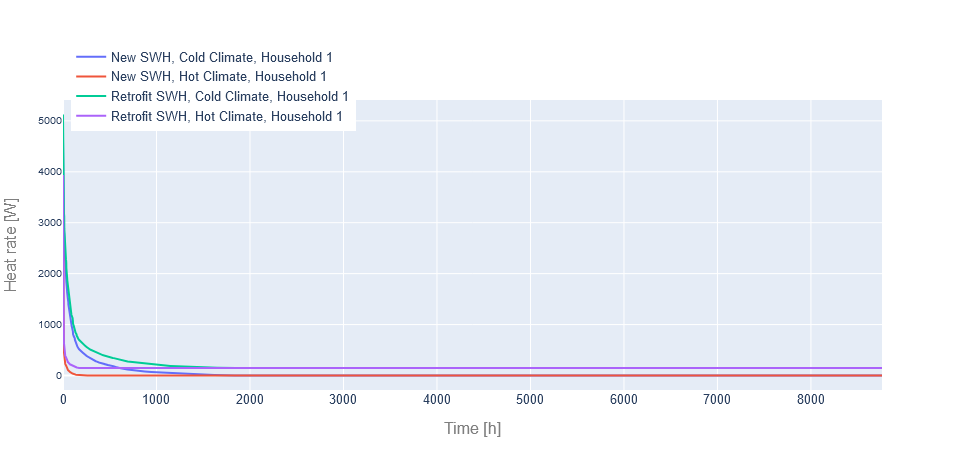

In [74]:
# climates: hot and cold
# configrations: retrofit and new

# single community system household

print('month, day, hour:\nData starts at', ts_res_com_retrofit_hot.loc[first_hour, ['month','day', 'hour']].transpose().values, 'and ends at',
ts_res_com_retrofit_hot.loc[last_hour, ['month','day', 'hour']].transpose().values)

df_gas_use = pd.DataFrame()

df_gas_use["New SWH, Cold Climate, Household 1"] = np.array(backup_ts_cons_com_new_cold[1][r['gas_use']])
df_gas_use["New SWH, Hot Climate, Household 1"] = np.array(backup_ts_cons_com_new_hot[1][r['gas_use']])
df_gas_use["Retrofit SWH, Cold Climate, Household 1"] = np.array(backup_ts_cons_com_retrofit_cold[1][r['gas_use']])
df_gas_use["Retrofit SWH, Hot Climate, Household 1"] = np.array(backup_ts_cons_com_retrofit_hot[1][r['gas_use']])

fig = Plot(data_headers = None, \
                 outpath = '', save_image = False, title = '', label_v = 'Heat rate [W]',\
                 legend = True, duration_curve = True, margin_l = m_l, margin_b = m_b,\
                 notebook_mode = True, width = w, height = h, fontsize = f, legend_x = .01, legend_y = 1.2).\
            series(df_gas_use, outfile = '', modes = 'lines')

## Solar thermal system validation

We performed validation with average energy savings and solar fractions for climate zone 3 for solar thermal systems with an instantaneous backup provided in the [SRCC OG-300](https://secure.solar-rating.org/Certification/Ratings/RatingsSummaryPage.aspx?type=2) rating data.

We also performed the component models validation. Those validation tests can be found in `swh.system.tests.test_components`.

In [75]:
# scaled loads to match 300L/day, as used to obtain the rating data
load_array_val = loads_indiv['End-Use Load'][0] * \
    (300*365*.001)/loads_indiv['End-Use Load'][0].sum()

loads_indiv_val = pd.DataFrame(data = \
     [[1, occ_ind[0], load_array_val]],\
    columns = \
     [c['id'], c['occ'], c['load_m3']])

In [76]:
# in a cold climate
sol_wh_indiv_new_val = System(sys_params = sol_the_sys_params_indiv,
                          backup_params = gas_tankless_wh_params,
                          sys_sizes = sys_sizes_val,
                          backup_sizes = new_bckp_size_ind,
                          weather = weather_val,
                          loads = loads_indiv_val)

cons_total_indiv_new_val, proj_total_indiv_new_val,\
[proj_total_dict_indiv_new_val, sol_fra_indiv_new_val, pump_el_use_indiv_new_val,\
 pump_op_hour_indiv_new_val, ts_res_indiv_new_val, backup_ts_cons_indiv_new_val, rel_err_indiv_new_val] = \
    sol_wh_indiv_new_val.solar_thermal(backup = 'gas')

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Assigned weather data timeseries.
INFO:mswh.system.components:Solar storage tank is set.
INFO:mswh.system.components:Assigned weather data timeseries.


In [77]:
# compare solar fraction for CZ03
rating_sheet_03 = 0.69
average_from_rating_sheet_for_similar_installations_03 = 0.72

proj_total_indiv_new_val['Solar Fraction']

0.68

In [78]:
# compare savings to basecase with the parameters corresponding the DOE appliance efficiency level 1
basecase_wh_val = System(sys_params = gas_tank_wh_params, 
            sys_sizes = gas_tank_wh_size, 
            weather = weather_val, 
            loads = loads_indiv_val)
bc_cons_total_el, bc_proj_total_el, bc_ts_proj_el = \
            basecase_wh_val.conventional_gas_tank()

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.


In [79]:
# compare savings (note that there is no information in the rating sheet on the basecase tank WH)

rating_sheet_03 = 4490
average_from_rating_sheet_for_similar_installations_03 = 4707.18

abs(((bc_proj_total_el['Energy Use - Gas']
    - proj_total_indiv_new_val['Energy Use - Gas'])/1000
    - average_from_rating_sheet_for_similar_installations_03)/average_from_rating_sheet_for_similar_installations_03).round(2)

0.14

In [80]:
# With baseline tank with a slightly higher RE and insulation set to R12, as used for the solar tank

gas_tank_wh_params_val = pd.DataFrame(data = \
    [[s['gas_tank'], s['tank_re'], .82, '-'], 
     [s['gas_tank'], s['ins_thi'], .04, 'm'], 
     [s['gas_tank'], s['spec_hea_con'], .085, 'W/mK'], 
     [s['gas_tank'], s['t_tap_set'], 322.04, 'K']], 
    columns = \
     [s['comp'], s['param'], s['param_value'], s['param_unit']])
basecase_wh_val = System(sys_params = gas_tank_wh_params_val,
            sys_sizes = gas_tank_wh_size, 
            weather = weather_val,
            loads = loads_indiv_val)
bc_cons_total, bc_proj_total, bc_ts_proj = \
            basecase_wh_val.conventional_gas_tank()

# gas use savings compared to baseline
(bc_proj_total['Energy Use - Gas'] - proj_total_indiv_new_val['Energy Use - Gas'])/1000

INFO:mswh.system.models:Assigned weather data timeseries.
INFO:mswh.system.components:Gas tank WH (WHAM) is set up.


4839.343414647049